# RAG 优化技巧

---

当你已经构建了基础的 RAG 系统，并见证它如何借助你的私有数据提升 LLM 的解答能力后，现在是进一步提升的时候了。

在本章中，我们将探索进阶的 RAG 技术，帮助你：

* 检索更准确、更相关的文档
* 减少幻觉
* 提升回答质量
* 处理复杂或模糊的查询

## 到目前为止的故事……

**场景：**
用户非常喜欢新上线的功能，他们可以直接与 **TaskFriend** 聊天分享自己的日常。然而，他们也发现 **TaskFriend** 有时无法检索到他们想要的信息。


## 目标

* 提升 **TaskFriend** 检索准确、相关任务的能力
* 减少因上下文缺失或无关而导致的错误回答
* 帮助 **TaskFriend** 理解复杂或模糊的查询，例如 `"I'm stuck — what should I do next?"`
* 通过优化 RAG 流水线，让 **TaskFriend** 提供更有帮助、更有依据的回答


## 初始化环境

### 设置 API Key

在任何笔记本开始之前，我们都需要加载 [Model Studio 的 API Key](https://modelstudio.console.alibabacloud.com/?tab=globalset#/efm/api_key)。这能确保我们可以调用整个课程中将使用到的 Qwen 模型 API。

> 如果你不确定如何找到 **Model Studio** 的 API Key，请参阅 `00 Setting Up the Environment` 文档。

In [1]:
# Load Model Studio API key
import os
from config.load_key import load_key
load_key(
    confirmation=False
)

Detected existing API key: sk-8...2716
Auto-confirmation enabled. Using existing API key.


### 配置 LLM 客户端

我们将使用 DashScope 提供的 OpenAI 兼容接口来与 Qwen 模型（以及本课程中会用到的其他模型）交互。


In [2]:
from openai import OpenAI

client = OpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

## 设置全局参数

我们将沿用上一章中使用的全局参数配置。

In [3]:
# Set global settings
import dashscope
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.dashscope import DashScopeEmbedding
from llama_index.llms.openai_like import OpenAILike



# Route DashScope calls to the mainland China endpoints
dashscope.base_http_api_url = "https://dashscope.aliyuncs.com/api/v1"

Settings.llm = OpenAILike(
    model="qwen-plus",
    api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    is_chat_model=True
)

Settings.embed_model = DashScopeEmbedding(
    model_name="text-embedding-v3",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    encoding_format="float"
)

print("✅ Global parameters set!")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     d:\github\LMP-C01\taskfriend\Lib\site-
[nltk_data]     packages\llama_index\core\_static/nltk_cache...
[nltk_data]   Package punkt_tab is already up-to-date!


✅ Global parameters set!


In [4]:
def highlight_words(text, words_to_highlight, emoji="⭐"):
    for word in words_to_highlight:
        if word in text:
            text = text.replace(word, f"{emoji}{word}{emoji}")
    return text


def get_rag_response_with_info(query, query_engine, highlight=None):
    print("🚀 TaskFriend Conversation (single-round)")
    print("-" * 50)
    print(f'👤 You: {query}')
    
    try:
        # 🔍 Query the RAG engine
        response = query_engine.query(query)

        # 🧠 Extract the answer
        if hasattr(response, 'response'):
            answer = response.response
        else:
            answer = str(response)

        # 📚 Show source references AFTER the answer
        print("🤖 TaskFriend:", answer)
        print('\n\n' + '=' * 50)
        print('📚 References\n')
        
        highlight = highlight or []
        for i, source_node in enumerate(response.source_nodes, start=1):
            print(f'Chunk {i}:')
            
            # Highlight words in chunk
            highlighted_text = highlight_words(source_node.text, highlight)
            print(highlighted_text)
            print()
        print('=' * 50)

        return answer

    except Exception as e:
        print(f"[RAG Error] {e}")
        return "[Error retrieving response]"

In [5]:
from llama_index.core import StorageContext, load_index_from_storage

persist_path = "./knowledge_base/taskfriend"

# Import index ("knowledgebase") we built last chapter
storage_context = StorageContext.from_defaults(
    persist_dir=persist_path,
)

index = load_index_from_storage(
    storage_context,
    embed_model=Settings.embed_model
)
print(f"✅ Index loaded from `{persist_path}`!")

# Build the query engine (used to implement RAG)
query_engine = index.as_query_engine(
    streaming=False,
    llm=Settings.llm,
    embed_model=Settings.embed_model
)
print("✅ Query engine built!")

✅ Index loaded from `./knowledge_base/taskfriend`!
✅ Query engine built!


# 提升 RAG 性能的基础策略

---

既然你已经学会如何评估 RAG 系统并找出薄弱环节，现在就该动手修复它们了。你已经看到各种症状——召回率低、准确率差、幻觉频发——接下来就是开药方。

优化 RAG 流水线并不是魔法，而是围绕关键组件做出聪明、精准的调整。下图展示了本章将介绍的基础优化策略流程图。这些也是当前最值得拉动、最具影响力的调优杠杆。

```mermaid
graph TD
    classDef frameworkStyle fill:#ffffff,stroke:#1f77b4,stroke-width:2px;
    classDef retrieval fill:#e3f2fd,stroke:#1976d2,stroke-width:2px;
    classDef embedding fill:#e8f5e8,stroke:#388e3c,stroke-width:2px;
    classDef chunking fill:#fff3e0,stroke:#f57c00,stroke-width:2px;

    subgraph flowchart [RAG 优化流水线]
        A[用户查询] --> B[检索]
        subgraph "优化：similarity_top_k"
            direction TB
            B --> C[向量库搜索]
            C --> D[检索 Top-K 文本块]
            style D fill:#e3f2fd,stroke:#1976d2
        end

        subgraph "优化：嵌入模型"
            direction TB
            E[嵌入模型] --> C
            style E fill:#e8f5e8,stroke:#388e3c
        end

        D --> F[拼装上下文]
        subgraph "优化：分块策略"
            direction TB
            G[分块策略] --> H[源文档]
            style G fill:#fff3e0,stroke:#f57c00
        end
        H --> I[创建向量索引]
        I --> E
        I --> C

        F --> J[LLM 生成]
        J --> K[最终回答]
    end

    class flowchat frameworkStyle

    class D retrieval
    class E embedding
    class G chunking

    style A fill:#f3e5f5,stroke:#7b1fa2
    style K fill:#f3e5f5,stroke:#7b1fa2
```

1. 通过调节 `similarity_top_k` 精细控制检索结果；
2. 选择合适的嵌入模型为语义搜索提供动力；
3. 掌握分块策略，让知识结构更合理。

这些不是简单的技术开关，而是决定 AI “思考方式”和检索能力的核心决策。我们会用实际示例逐一拆解，向你展示如何把一个表现平平的 RAG 打造成高效能系统。



让我们开始，让 TaskFriend 变得更聪明。


## `similarity_top_k`：控制 RAG 能看到什么
 
让我们回到熟悉的示例——上一章做过的内容，我们再跑一遍。

In [6]:
# User query
query = "How many tasks are due today, and what are they?"

# Choose words to highlight
highlight = ["Today"]

response = get_rag_response_with_info(query, query_engine=query_engine, highlight=highlight)

🚀 TaskFriend Conversation (single-round)
--------------------------------------------------
👤 You: How many tasks are due today, and what are they?
🤖 TaskFriend: Two tasks are due today. They are:

1. Finalize Q3 OKRs by 3pm – involving collaboration with department heads to align on measurable objectives, creating a plan to achieve them, and assigning responsibilities.
2. Update Project Phoenix roadmap – requiring coordination with project leads to reflect updated timelines, milestones, and resource allocations, considering recent supply-chain disruptions.


📚 References

Chunk 1:
Tasks   ID Task Type Due Status Notes 
01 Finalize Q3 OKRs by 3pm One-oﬀ ⭐Today⭐ Pending  Collaborate with department heads to align on measurable objecDves, lay out solid plan to achieve objecDves and assign responsibility to team members.   
02 Prepare presentaDon for client review One-oﬀ This Week Pending  Focus on deliverables from Q2, highlight success metrics, and outline next steps. Obtain client feed

现在我们可以看到 **TaskFriend**：

* 只从索引中取回了两个上下文块
* 每个块都只出现了一次单词 `today`
* 根据检索到的内容，得出今天只有两个任务到期

那么，为什么 **TaskFriend** 只能看到两个文本块？其他上下文都去哪了？

原因在于 `query_engine` 函数的工作方式。

```python
query_engine = index.as_query_engine(
    ...
    similarity_top_k=2       # ← 默认值是 2
)
```

`query_engine` 接收 `similarity_top_k` 参数，默认值为 `2`。这意味着它会根据输入查询，返回语义上最相似的前两个文本块。

因此，即使索引中还有更多相关的块——例如其他今天到期的任务——只要没有进入前两名，它们就不会被检索出来，也不会被传给 LLM 参与推理。所有排在 Top-K 之外的内容，对 TaskFriend 来说都是“不可见”的。

这正是 RAG 系统的关键限制：模型只能基于检索到的上下文进行推理，而不是整个知识库。只要相关信息没进入 Top-K，就不会被考虑，最终导致回答不完整甚至错误。

概括来说，我们现在得到的是：

```
[任务文本块的向量索引]
│
├── Chunk 0: "Finalize Q3 OKRs - today by 3pm"                     ← ✅ 已检索（高相关）
├── Chunk 1: "Update Project Phoenix roadmap – due today"          ← ✅ 已检索
├── Chunk 2: "Renew cloud subscription – due today"  ← ❌ 未检索到
├── Chunk 3: "Update documentation – due tomorrow"
├── Chunk 4: "Onboard new intern – due next week"
│
↓
[LLM 输入上下文]

"""
You need to complete one task today:
- Submit Q3 report – due today
"""

🧠 LLM 输出：“You have 2 tasks due today.”
❌ 遗漏：“Renew cloud subscription”
```

现在，让我们试着调整 `similarity_top_k` 参数：

In [7]:
# Rebuild query engine with custom similarity_top_k argument
query_engine = index.as_query_engine(
    streaming=True,
    llm=Settings.llm,
    embeddings=Settings.embed_model,
    similarity_top_k=5       # ← The default value is 2
)
print("✅ Query engine built!")
print("\nUsing existing query settings...\n")
response = get_rag_response_with_info(query, query_engine=query_engine, highlight=highlight)

✅ Query engine built!

Using existing query settings...

🚀 TaskFriend Conversation (single-round)
--------------------------------------------------
👤 You: How many tasks are due today, and what are they?
🤖 TaskFriend: There are 4 tasks due today. They are:

1. Finalize Q3 OKRs by 3pm  
2. Update Project Phoenix roadmap  
3. Onboard new team member  
4. Write thank-you letter to penpal in Korea


📚 References

Chunk 1:
Tasks   ID Task Type Due Status Notes 
01 Finalize Q3 OKRs by 3pm One-oﬀ ⭐Today⭐ Pending  Collaborate with department heads to align on measurable objecDves, lay out solid plan to achieve objecDves and assign responsibility to team members.   
02 Prepare presentaDon for client review One-oﬀ This Week Pending  Focus on deliverables from Q2, highlight success metrics, and outline next steps. Obtain client feedback on presentaDon and tweak direcDon based on

Chunk 2:
05 Update Project Phoenix roadmap One-oﬀ ⭐Today⭐ Pending  Sync with project leads to reﬂect latest Dmelines,

太好了！通过增加检索的文本块数量，我们成功找到了更多今天到期的任务。`similarity_top_k` 确实为我们提供了一种快捷方式来获取所需内容——但这真的是最佳做法吗？

照这个逻辑，我们完全可以把 `similarity_top_k` 设成整个索引的大小，检索所有文本块，保证不会漏掉任何东西。然而，现实中存在非常实际的限制，使得这种做法不切实际：



结合上一章学到的评估指标，我们也许能得到更多洞见：

In [8]:
from langchain_openai import ChatOpenAI
from langchain_dashscope import DashScopeEmbeddings
from datasets import Dataset
import os
import time

dashscope.base_http_api_url = "https://dashscope.aliyuncs.com/api/v1"

# LangChain LLM for Ragas
ragas_llm = ChatOpenAI(
    model="qwen-plus",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    timeout=60,
    max_retries=3
)

# LangChain Embeddings for Ragas
ragas_embeddings = DashScopeEmbeddings(
    model="text-embedding-v3",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
)

print("✅ LLM and Embeddings pipeline for Ragas successfully built!")

✅ LLM and Embeddings pipeline for Ragas successfully built!


In [9]:
from ragas import evaluate
from ragas.metrics import (
    context_recall,
    context_precision,
    answer_correctness,
    faithfulness
)
from functions.rag_eval_table import create_rag_evaluation_table

def eval_output(query_engine, question, ground_truth):
    print("Performing evaluation...", end="", flush=True)
    start_time = time.time()

    # Run query
    response = query_engine.query(question)

    # Extract answer and context
    if hasattr(response, 'get_response'):
        completed_response = response.get_response()
        answer = getattr(completed_response, 'response', str(completed_response))
    else:
        answer = getattr(response, 'response_txt', str(response))
    
    # Ensure answer is a proper string
    answer = str(answer) if answer is not None else "No answer generated"
    
    # Get retrieved contexts
    contexts = []
    for node in response.source_nodes:
        content = node.get_content()
        # Ensure it's a non-empty string
        if content is not None:
            content_str = str(content).strip()
            if content_str:  # only add non-empty strings
                contexts.append(content_str)
    
    # 🛡️ RAGAS REQUIREMENT: contexts must be a list of strings (never empty list)
    if not contexts:
        contexts = [""]  # Ragas expects at least one string

    # Construct evaluation dataset
    data_samples = {
        'question': [str(question)],
        'answer': [answer],
        'ground_truth': [str(ground_truth)],
        'contexts': [contexts],
    }
    dataset = Dataset.from_dict(data_samples)

    # Use Ragas for evaluation
    score = evaluate(
        dataset=dataset,
        metrics=[
            answer_correctness, 
            context_recall, 
            context_precision, 
            faithfulness
        ],
        llm=ragas_llm,
        embeddings=ragas_embeddings
    )
    
    load_time = time.time() - start_time
    print(f" ✅ Done ({load_time:.1f} seconds)")

    # Get results as DataFrame
    results_df = score.to_pandas()
    
    # Display the styled HTML table
    styled_table = create_rag_evaluation_table(results_df, column_widths=[10, 10, 10, 40, 10, 10, 10], show_contexts=False)
    return styled_table

In [10]:
# Set question & ground_truth
question = "How many tasks do I need to complete today? State the task and short description"
ground_truth = """
    You have 3 tasks due today:
    1. Finalize Q3 OKRs by 3pm – collaborate with department heads to align on measurable objectives.
    2. Update 'Project Phoenix' roadmap – sync with project leads to reflect latest timelines, 
    milestones, and resource allocations.
    3. Write thank-you letter to penpal in Korea
"""
eval_output(query_engine=query_engine, question=question, ground_truth=ground_truth)

Performing evaluation...

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

 ✅ Done (29.3 seconds)


question,answer,ground_truth,contexts,answer_correctness,context_recall,context_precision,faithfulness
How many tasks do I need to complete today? State the task and short description,"You need to complete 3 tasks today: - Finalize Q3 OKRs by 3pm: Collaborate with department heads to align on measurable objectives, lay out a solid p...",You have 3 tasks due today: 1. Finalize Q3 OKRs by 3pm – collaborate with department heads to align on measurable objectives. 2. Update '...,No contexts,0.623,1.0,0.0,1.0


基于结果，我们可以得出一些推论（具体数值可能略有差异，但整体趋势应相近）：

|  指标                |  得分          |  说明               |  结论    |
|------------------------|-----------------|-----------------------------|---------------|
|  答案正确率    | 中等 (0.54)      | <ul><li>模型正确识别出今天到期的 **4 个任务中的 2 个**：`Finalize Q3 OKRs` 和 `Update project roadmap`。</li><li>漏掉了两个任务：`Onboard new team member` 和 `Write thank-you letter`。</li></ul>   |  答案部分正确，但不完整。    |
|  上下文召回率        | 高 (0.80)      | <ul><li>在实际应检索到的 4 个任务（标记为今日到期）中，**找到了 3 个**：`Finalize Q3 OKRs`、`Update project roadmap` 和 `Onboard new team member`。</li><li>仅缺失 `Write thank-you letter`。</li></ul>   |  检索器大致有效，但仍漏掉一个相关上下文。    |
|  上下文精确率     | 0 (0.00)     | <ul><li>模型共检索到 **5 个上下文**，但只有 **2 个**（`Finalize Q3 OKRs`、`Update project roadmap`）是真正今天到期的任务。</li><li>另外 3 个要么是更晚到期，要么完全无关（如 `Clean up inbox`、`Call bank` 等）。</li></ul>    |  检索器缺乏精确度——拉来了大量无关内容。    |

# RAG 流水线：从检索到增强再到生成

---

既然你已经了解调整 `similarity_top_k` 如何帮助 **TaskFriend** 看到更多任务，接下来就要学习提升 RAG 性能的整体策略。但在此之前，我们需要先理解整条 RAG 流水线。

```mermaid
graph LR
  subgraph Ingest["文档导入（LlamaIndex）"]
  direction TB
    KB[知识库] --> PreP["预处理<br>文档"]
  end
  subgraph RAG["RAG（LlamaIndex + Langchain）"]
  direction LR
    PreP -- 文档 --> Emb[嵌入<br>模型]
    Emb -- 文档<br>向量 --> vDB[(向量数据库)]
      vDB -- "提示词 + 查询<br>+ 检索上下文" --> LLM
  end
  Usr[用户] --> Chatbot
  Chatbot -- 用户查询 --> Emb
  Emb -- 查询向量 --> vDB
  subgraph Input
  direction LR
      Usr
      Chatbot
  end
  LLM -- 生成回答 --> Chatbot
```

**工作原理**
1. 文档导入
    * 流程从你的知识库开始（例如任务列表、文档、FAQ 等）。
    * 这些文档会进入预处理阶段，在这里进行清洗、切分和索引准备。
2. 嵌入与存储
    * 文本块会通过嵌入模型转换成数值向量。
    * 这些向量存储在向量数据库中，便于高效语义检索。
3. 用户查询流程
    * 当用户提交问题时，聊天机器人会将其发送到同一个嵌入模型。
    * 查询被转换成查询向量，落在与文档相同的向量空间中。
4. 检索
    * 系统在向量数据库中查找最相关的文本块（通过相似度搜索）。
    * 检索到的上下文会与原始问题和提示模板组合。
5. 生成
    * “提示词 + 查询 + 检索上下文” 这一增强输入会被发送到 LLM。
    * LLM 生成带上下文的回答，再返回给聊天机器人供用户查看。

# 预处理：让 RAG 拥有“看清”数据的能力

---

预处理阶段决定了 RAG 系统的“视力”——能否在合适的粒度获取准确信息。它包含两个核心环节：文档准备与分块策略。

## 将合适的知识匹配给用户需求

在优化检索或生成之前，先确保 RAG 系统拥有正确的基石：高质量的知识。

换个角度看：

* 用户的提问基于他们的需求——这构成了**意图空间（intent space）**。
* 你的知识库保存着答案——这构成了**知识空间（knowledge space）**。

| 维度 | 意图空间 | 知识空间 |
|-------|----------------|-------------------|
| **定义** | 用户通过查询表达的所有潜在目标或需求。 | RAG 系统可访问的事实、文档与结构化信息集合。 |
| **关注点** | *“用户想要什么？”*——理解目的、语境与查询类型。 | *“系统知道什么？”*——提供可检索、可引用的内容。 |
| **示例** | “比较两件商品”、“重置密码”、“解释某个原理” | 内部文档、FAQ、产品规格、研究论文、数据库 |
| **在 RAG 中的角色** | 通过识别查询类型（如事实、比较、流程）来指导检索，使查询更加意图感知。 | 作为检索来源——从中提取上下文，增强 LLM 提示。 |
| **关键机制** | 自然语言理解（NLU）、意图分类模型 | 向量数据库、语义搜索、知识图谱 |
| **若失配** | 系统误解用户目标 → 检索出错误内容 | 系统缺乏必要知识 → 可能幻觉或没有结果 |
| **优化策略** | 使用查询改写、意图标注、多查询检索，更好捕获用户意图 | 提升文档覆盖率、清理过时内容、优化分块以提升可检索性 |

要让 RAG 应用效果良好，这两个空间必须有重叠。

| 场景  | 含义  | 如何修复  |
|-----------|-----------------|-------------|
| 有重叠  | 问题在你的文档覆盖范围内 → RAG 能答好。  | 提升内容质量与检索准确度。  |
| 缺知识  | 用户提问的是新内容（如新产品）→ RAG 可能“幻觉”。  | 添加新文档，定期更新知识库。  |
| 结果不相关  | 检索到了错误或无关内容 → 让 LLM 困惑。  | 改进分块、嵌入或检索逻辑，移除过时内容。  |

> **关键洞察：**  
> **意图空间** 告诉 RAG 要找什么。
> **知识空间** 告诉 RAG 去哪里找。
> 只有当二者**对齐**时，RAG 才能提供准确、相关、值得信赖的回答。

## 文档准备：从干净、结构化的输入开始

输出质量取决于输入质量。真实世界中的文档格式繁多——PDF、Word、Keynote——还常混杂表格、图片、复杂排版。

**常见挑战与解决方案**  

| 问题  | 影响  | 解决方案  |
|--------|---------|-----------|
| 不支持的文件格式（如 `.key`、`.py`、`.json` 等）   | 解析器无法“读取”文件，导致知识空间出现空白  | 转换为标准格式，如 `.pdf`、`.txt`、`.md` 等  |
| 提取质量差（如表格破碎、图片缺失）  | 关键信息丢失或被扭曲  | 选择能保留结构的解析器，或使用 LLM 进行后处理润色  |
| 图片内嵌文字（如截图中的命令）  | 标准 OCR 无法捕获文字  | 使用视觉语言模型（VLM）识别图片内容并纳入知识库  |


### 将输入文档转换为 Markdown

`.pdf` 这类格式对人类友好，但对机器理解并不轻松。把文档转换成 Markdown (`.md`) 可以提升应用对文档的理解能力，其优势包括：

* 更明确的结构与层级
    * Markdown 支持标题（`#`、`##` 等）、列表、代码块、强调。
    * 有助于分块策略按章节划分内容，使切分更有语义。
    * 更好的分块 → 更连贯的上下文 → 更相关的检索结果。

* 更清晰的语义
    * 标题和小节是天然的元数据。
    * 例如查询 “Explain the methodology” 更容易匹配到 `## Methodology` 开头的块。
    
* 保留关键格式
    * 代码块（```）与行内代码（`）能区分技术术语或命令，对技术文档的准确检索至关重要。
    * 扩展 Markdown 支持列表与表格，保留条目之间的关系。

当然，它也有缺点：

* **格式糟糕的 Markdown：** 如果标题乱用或不一致，结构会误导系统。
* **过度分块：** 小节拆得太细会破坏上下文，反而影响检索质量。
* **元数据丢失：** Markdown 默认不带元数据（如作者、时间），需通过前置 YAML（如 `title:`、`source:`）补充。


为了方便理解，下面列出将文档转换为 Markdown 的利弊对照表：

| 维度 | Markdown 对 RAG 检索的影响 | 备注 / 最佳实践 |
|--------|-------------------------------------|----------------------------|
| **文档结构** | ✅ 改善 | 使用标题（`#`、`##`）构建层级，帮助检索系统定位相关段落。 |
| **语义清晰度** | ✅ 改善 | 标题是天然的查询匹配信号（例如“## Methodology”对应“方法论”相关问题）。 |
| **文本分块** | ✅ 改善 | 支持更聪明、语义感知的分块（按章节），提升检索相关度。 |
| **格式保留** | ✅ 改善 | 保留代码块、列表、强调，对于技术或结构化内容尤为关键。 |
| **处理效率** | ✅ 改善 | 纯文本、轻量化，相对 PDF/HTML 更易解析、索引、清洗。 |
| **元数据支持** | ⚠️ 受限 | 原生 Markdown 缺少元数据，可用 YAML 前置补充（如 `title:`、`source:`）。 |
| **格式质量风险** | ❌ 可能有害 | 标题或列表不规范会误导检索。内容质量比格式更重要。 |
| **过度分块风险** | ⚠️ 可能有害 | 过小的片段会破坏上下文，需要平衡块大小与连贯性。 |
| **非万能解** | ⚠️ 中性 | Markdown 不能单独解决内容质量或嵌入模型问题。需与高质量文本和模型配合。 |
| **最佳实践** | — | • 使用语义一致的标题<br>• 按章节边界分块<br>• 保留代码/列表/表格<br>• 通过前置元数据补充信息<br>• 转换后测试检索效果 |

现在，让我们做个小实验，把 `./docs/taskfriend/tasks.pdf` 转成 Markdown：

In [11]:
import fitz  # PyMuPDF
import pymupdf4llm  # For Markdown conversion

# Convert PDF to Markdown
def pdf_to_md(pdf_path):
    doc = fitz.open(pdf_path)
    md_text = pymupdf4llm.to_markdown(doc)
    doc.close()
    return md_text

# Convert your file
md_content = pdf_to_md("./docs/taskfriend/tasks.pdf")

print("📄 Raw Markdown Output:")
print("-" * 100)
print(md_content)

📄 Raw Markdown Output:
----------------------------------------------------------------------------------------------------
# TaskFriend Task Database

## What is TaskFriend?

### TaskFriend is a helpful AI-assistant that helps with managing your daily tasks, and provides advice on =me management and project scheduling.

## What are tasks?

### Tasks are the smallest denomina=on of work you can achieve in TaskFriend. You can set tasks, type, due dates, status, and notes. This gives you full insight into your life and priori=es, helping you beBer manage your =me.


## Tasks












|ID|Task|Type|Due|Status|Notes|
|---|---|---|---|---|---|
|01|Finalize Q3 OKRs<br>by 3pm|One-oﬀ|Today|Pending|<br>Collaborate<br>with<br>department<br>heads to align<br>on<br>measurable<br>objecDves, lay<br>out solid plan<br>to achieve<br>objecDves<br>and assign<br>responsibility<br>to team<br>members.<br>|
|02|Prepare<br>presentaDon for<br>client review|One-oﬀ|This<br>Week|Pending|<br>Focus on<br>deliver

正如你所见，原始输出与我们之前得到的文本块相差无几——存在拼写错误，表格在分页时被“拆碎”。这些都属于我们刚提到的 Markdown 转换缺点。不过事情并未结束，我们可以借助 LLM：把原始 `.md` 输出喂给模型，让它修复大部分问题：

In [12]:
from dashscope import Generation

def md_polisher(markdown_text, model="qwen-plus"):
    prompt = f"""
The following Markdown text is converted from a PDF. Please fix and polish it:
1. Fix heading hierarchy and missing info.
2. Correct inconsistent context or tables.
3. Ensure lists and code blocks are properly formatted.
4. Do NOT invent new content.
5. Output only the cleaned Markdown.

Content:
{markdown_text}
"""
    messages = [{'role': 'user', 'content': prompt}]
    
    response = Generation.call(
        model=model,
        messages=messages,
        result_format='message',
        stream=True,
        incremental_output=True  # Good for long responses
    )
    
    result = ""
    print("✨ Polished Markdown:")
    print("-" * 50)
    for chunk in response:
        content = chunk.output.choices[0].message.content
        print(content, end='')
        result += content
    return result

# Polish the output
polished_md = md_polisher(md_content)

# Optional: Save to file
with open("./docs/tasks_polished.md", "w", encoding="utf-8") as f:
    f.write(polished_md)


print("\n\n" + "-" * 50)
print("✅ Saved polished Markdown to ./docs/tasks_polished.md")

✨ Polished Markdown:
--------------------------------------------------
# TaskFriend Task Database

## What is TaskFriend?

TaskFriend# TaskFriend Task Database

## What is TaskFriend?

TaskFriend is a helpful AI-assistant that helps with managing your daily tasks, and provides advice is a helpful AI-assistant that helps with managing your daily tasks, and provides advice on time management and project scheduling.

## What are Tasks?

Tasks are on time management and project scheduling.

## What are Tasks?

Tasks are the smallest denomination of work you can achieve in TaskFriend. the smallest denomination of work you can achieve in TaskFriend. You can set task details such as type, due dates, status, You can set task details such as type, due dates, status, and notes. This gives you full insight into your life and priorities, helping you better manage your time.

## Tasks and notes. This gives you full insight into your life and priorities, helping you better manage your time.

## Tas

如果你更喜欢 `.md` 列表格式，也可以调整提示词，让润色结果符合你的要求。

In [13]:
def md_polisher_to_list(markdown_text, model="qwen-plus"):
    prompt = f"""
The following Markdown text is converted from a PDF. Please fix and polish it:
1. Fix heading hierarchy and missing info.
2. Correct inconsistent context or tables.
3. Format as a clean markdown list grouped by due date.
4. Summarize notes as a single, concise sentence.
5. Output only the cleaned Markdown.

[Examples]
# Completed
ID: <task_id> | <task_name> - <recurring> task due <due>, <summarized notes>.

## Due Today
ID: <task_id> | <task_name> - <recurring> task due <due>, <summarized notes>.

## Due This Week
ID: <task_id> | <task_name> - <recurring> task due <due>, <summarized notes>.

Content:
{markdown_text}
"""
    messages = [{'role': 'user', 'content': prompt}]
    
    response = Generation.call(
        model=model,
        messages=messages,
        result_format='message',
        stream=True,
        incremental_output=True  # Good for long responses
    )
    
    result = ""
    print("✨ Polished Markdown:")
    print("-" * 50)
    for chunk in response:
        content = chunk.output.choices[0].message.content
        print(content, end='')
        result += content
    return result

# Polish the output
polished_md = md_polisher_to_list(md_content)

# Optional: Save to file
with open("./docs/taskfriend/tasks_list_polished.md", "w", encoding="utf-8") as f:
    f.write(polished_md)


print("\n\n" + "-" * 50)
print("✅ Saved polished Markdown to ./docs/taskfriend/tasks_list_polished.md")

✨ Polished Markdown:
--------------------------------------------------
# Completed
ID: 03 | Onboard new team member -# Completed
ID: 03 | Onboard new team member - One-off task due Today, Schedule intro meetings with team members, send One-off task due Today, Schedule intro meetings with team members, send welcome email with onboarding checklist, assign mentor for first 30 welcome email with onboarding checklist, assign mentor for first 30 days; Karen was assigned as the mentor.

## Due Today
 days; Karen was assigned as the mentor.

## Due Today
ID: 01 | Finalize Q3 OKRs by 3pmID: 01 | Finalize Q3 OKRs by 3pm - One-off task due Today, Collaborate with department heads to align - One-off task due Today, Collaborate with department heads to align on measurable objectives, lay out solid plan to on measurable objectives, lay out solid plan to achieve objectives, and assign responsibility to team members.
ID: 05 | achieve objectives, and assign responsibility to team members.
ID: 05 | Upd

这是一个简单但高效的流程：先把 `.pdf` 转成 `.md`，再修复潜在问题，从而充分利用结构化格式，为 RAG 系统打好基础。

## 分块：在上下文与精度之间寻找平衡

分块决定了文档在被嵌入和存储之前如何拆分。块太小会丢失上下文，块太大又会引入噪音。

不存在“一刀切”的方法——以下是最常用的策略：

| 方法  | 最适合场景  | 核心优势  |
|---------|-----------|--------------|
| 句子切分  | 通用场景  | 保留句子边界，结构清晰可控  |
| Token 切分  | 模型上下文窗口严格受限时  | 精确控制 Token 数  | 
| 句窗法  | 对上下文要求高的查询  | 在检索时附带上下文窗口  | 
| 语义切分  | 技术文档或复杂内容  | 基于语义而非长度进行切分  | 
| Markdown 切分  | 文档、README、结构化内容  | 尊重标题与章节结构，适合层级知识  | 

**如何选择？**

* **刚入门？** 使用句子切分，适配大多数场景。
* **长文档？** 尝试句窗法或语义切分。
* **使用 Markdown 文档？** 用 MarkdownNodeParser 保留章节边界。
* **频繁触碰上下文上限？** 改用带重叠的 Token 切分。

> 没有任何方法是**完美**的。  
> 使用评估指标（如检索准确度、回答相关度）测试不同分块方式，并不断迭代。

在介绍不同分块方法之前，我们先加载依赖，并写一个方便对比分块效果的函数：


In [14]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
    SentenceWindowNodeParser,
    MarkdownNodeParser,
    TokenTextSplitter
)
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

documents = SimpleDirectoryReader(
    input_dir="./docs/taskfriend",
    required_exts=[".md"],
    recursive=False
).load_data()

def eval_splitter(splitter, documents, question, ground_truth, splitter_name):
    print(f"\n{'='*50}")
    print(f"🔍 EVALUATING: {splitter_name}")
    print(f"{'='*50}\n")
    

    print("🧱 Parsing documents into chunks...")
    nodes = splitter.get_nodes_from_documents(documents)
    print(f"   → Created {len(nodes)} chunks")
    index = VectorStoreIndex(nodes, embed_model=Settings.embed_model)

    query_engine = index.as_query_engine(
        similarity_top_k=5,
        streaming=True
    )

    print(f"\n👤 You: {question}")
    print("\n🤖 TaskFriend:")
    response = query_engine.query(question)
    response.print_response_stream()

    # Show retrieved contexts
    print(f"\n\n📌 Retrieved contexts:")
    print(f"{'-'*50}\n")
    source_contexts = [node.get_content() for node in response.source_nodes]
    for i, ctx in enumerate(source_contexts):
        ctx_len = len(ctx)
        print(f"Chunk {i+1} | {ctx_len} chars:\n{ctx}\n")

    # Show evaluation table
    print(f"\n📊 {splitter_name} evaluation:")
    print("-" * 50)
    display(eval_output(query_engine, question, ground_truth))

### 句子切分

**工作原理**：  
按照自然的句子边界（如 `.`, `!`, `?`）结合启发式规则切分文本，直到达到设定的字符或 Token 限制。


```
原始文本：
┌────────────────────────────────────────────────────────────┐
│ Allen loves AI. He reads papers daily. LLMs are amazing!   │
└────────────────────────────────────────────────────────────┘

句子切分后：
┌─────────────────┐ ┌────────────────────────┐ ┌─────────────────────┐
│ Allen loves AI. │ │ He reads papers daily. │ │ LLMs are amazing!   │
└─────────────────┘ └────────────────────────┘ └─────────────────────┘
     块 1                块 2                         块 3
```

**优点** ✅
* 保留自然语言的语序流畅性
* 运行速度快、计算成本低
* 易于通过 `chunk_size`（按字符或 Token）配置
* 适用于大多数文本类型

**缺点** ❌
* 可能产生非常短的块（例如 “Yes.” 或 “见上”）
* 若关键语义跨越多句，可能打断上下文
* 相比 Token 切分，对 LLM 上下文限制控制不够精确

**适用场景**
* 初次构建 RAG 流水线
* 文本标点清晰、语句规整
* 需要一个简单可靠的基线切分器

In [15]:
sentence_splitter = SentenceSplitter(
    chunk_size=100,
    chunk_overlap=20
)
eval_splitter(sentence_splitter, documents, question, ground_truth, "SentenceSplitter")


🔍 EVALUATING: SentenceSplitter

🧱 Parsing documents into chunks...
   → Created 10 chunks

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:
YouYou need to complete 3 tasks need to complete 3 tasks today:

 today:

- Finalize Q- Finalize Q3 OKRs by 33 OKRs by 3pm: Collaborate with departmentpm: Collaborate with department heads to align on measurable objectives heads to align on measurable objectives, lay out a solid, lay out a solid plan to achieve them plan to achieve them, and assign responsibility to team, and assign responsibility to team members.  
- Update members.  
- Update Project Phoenix roadmap: Sync Project Phoenix roadmap: Sync with project leads to reflect latest with project leads to reflect latest timelines, milestones, and resource timelines, milestones, and resource allocations, accounting for supply-chain alloc

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

 ✅ Done (31.2 seconds)


question,answer,ground_truth,contexts,answer_correctness,context_recall,context_precision,faithfulness
How many tasks do I need to complete today? State the task and short description,"You need to complete 3 tasks today: - Finalize Q3 OKRs by 3pm: Collaborate with department heads to align on measurable objectives, lay out a solid p...",You have 3 tasks due today: 1. Finalize Q3 OKRs by 3pm – collaborate with department heads to align on measurable objectives. 2. Update '...,No contexts,0.604,0.75,0.0,1.0


### Token 切分

**工作原理**：  
基于 **Token**（LLM 理解的最小单位）来切分文本。当达到设定的 `chunk_size` 时，就进行分割。


```
文本：
The quick brown fox jumps over the lazy dog near the park.


Tokens:
[The][ quick][ brown][ fox][ jumps]  [ over][ the][ lazy][ dog][ near]  [ the][ park][.]


块：
┌───────────────────────────┐ ┌────────────────────────┐ ┌──────────────┐
│ The quick brown fox jumps │ │ over the lazy dog near │ │ the park .   │
└───────────────────────────┘ └────────────────────────┘ └──────────────┘
         块 1                      块 2                块 3
```

**优点** ✅   
* 与 LLM 的上下文窗口精确对齐（如 512、1024、8192 Token）
* 最准确地避免 `context_length_exceeded` 错误
* 支持重叠，确保块之间保留上下文

**缺点** ❌  
* 可能在词或句子中间切断，降低可读性
* 需要与模型使用同一分词器
* 相比字符切分更加复杂

**适用场景**
* 需要精确控制 Token 用量
* 使用上下文窗口较紧的模型
* 构建面向生产的 RAG 系统

In [16]:
token_splitter = TokenTextSplitter(
    chunk_size=100,
    chunk_overlap=20
)
eval_splitter(token_splitter, documents, question, ground_truth, "Token")


🔍 EVALUATING: Token

🧱 Parsing documents into chunks...
   → Created 10 chunks

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:
YouYou need to complete need to complete  3 tasks today3 tasks today:

- Finalize Q:

- Finalize Q3 OKRs by 33 OKRs by 3pm: Collaborate withpm: Collaborate with department heads to align on measurable department heads to align on measurable objectives, lay out a solid objectives, lay out a solid plan to achieve them plan to achieve them, and assign responsibility to team, and assign responsibility to team members.  
- Update members.  
- Update Project Phoenix roadmap: Sync Project Phoenix roadmap: Sync with project leads to reflect latest with project leads to reflect latest timelines, milestones, and resource timelines, milestones, and resource allocations, accounting for supply-chain allocations, acc

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

 ✅ Done (26.5 seconds)


question,answer,ground_truth,contexts,answer_correctness,context_recall,context_precision,faithfulness
How many tasks do I need to complete today? State the task and short description,"You need to complete 3 tasks today: - Finalize Q3 OKRs by 3pm: Collaborate with department heads to align on measurable objectives, lay out a solid p...",You have 3 tasks due today: 1. Finalize Q3 OKRs by 3pm – collaborate with department heads to align on measurable objectives. 2. Update '...,No contexts,0.663,1.0,0.25,1.0


### 句窗法（Sentence Window）

**工作原理**：  
存储时保持较小、精细的块（如单句），但在检索阶段，会返回匹配句子**以及前后 N 句**（即“窗口”）。


```
原始文本：
[ S1 ][ S2 ][ S3 ][ S4 ][ S5 ][ S6 ][ S7 ]

存储的节点（window_size=2）：
┌──────────────────────────────┐
│ ... S2 S3 [S4] S5 S6 ...     │ ← S4 对应的节点
└──────────────────────────────┘

匹配 S4 → 返回完整窗口
```

✅ **优点**
- 📚 即使使用细粒度块，也能检索到丰富上下文
- 🎯 提升**回答真实性**与依据性
- 🔍 兼顾高精度检索与完整语境

❌ **缺点**
- 💾 增加元数据存储开销（需要保存窗口内容）
- ⏳ 由于后处理，速度略慢
- 🧠 需要在检索后组装上下文

🔧 **适用场景**
- 希望最大化答案正确性和依据
- 使用句子级别索引
- 在意**检索质量**胜过速度

In [17]:
sentence_window_splitter = SentenceWindowNodeParser.from_defaults(
    window_size=3,
    window_metadata_key="window",
    original_text_metadata_key="original_text"
)
# To visualize sentence window, we need to use 
query_engine = index.as_query_engine(
    similarity_top_k=5,
    streaming=True,
    node_postprocessors=[MetadataReplacementPostProcessor(target_metadata_key="window")]
)
eval_splitter(sentence_window_splitter, documents, question, ground_truth, "Sentence Window")


🔍 EVALUATING: Sentence Window

🧱 Parsing documents into chunks...
   → Created 10 chunks

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:
YouYou need to complete 2 need to complete 2 tasks today.

 tasks today.

- Finalize Q3- Finalize Q3 OKRs by 3pm OKRs by 3pm: Collaborate with department: Collaborate with department heads to align on measurable objectives heads to align on measurable objectives, lay out a solid, lay out a solid plan to achieve them plan to achieve them, and assign responsibility to team, and assign responsibility to team members.  
- Update members.  
- Update Project Phoenix roadmap: Project Phoenix roadmap: Sync with project leads Sync with project leads to reflect latest timelines, milestones to reflect latest timelines, milestones, and resource allocations, accounting, and resource allocations, accounting

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

 ✅ Done (24.2 seconds)


question,answer,ground_truth,contexts,answer_correctness,context_recall,context_precision,faithfulness
How many tasks do I need to complete today? State the task and short description,"You need to complete 2 tasks today. - Finalize Q3 OKRs by 3pm: Collaborate with department heads to align on measurable objectives, lay out a solid p...",You have 3 tasks due today: 1. Finalize Q3 OKRs by 3pm – collaborate with department heads to align on measurable objectives. 2. Update '...,No contexts,0.78,0.75,0.0,0.909


### 语义切分

**工作原理**：  
利用嵌入模型检测文本中的**语义转折**。只有当相邻片段的语义相似度显著下降时才切分。


```
原文：
┌───────────────────────────────────────────────────────────────────┐
│ Kitty plays guitar. She loves music.   ▶︎   She works as a lawyer. │
└───────────────────────────────────────────────────────────────────┘
                                         ↑
                         语义转折：爱好 → 工作

切分后：
┌───────────────────────────────────────┐ ┌──────────────────────────┐
│ Kitty plays guitar. She loves music.  │ │ She works as a lawyer.   │
└───────────────────────────────────────┘ └──────────────────────────┘

```


✅ **优点**
- 🧠 尊重语义与主题边界
- 🎯 将相关想法保留在同一块中
- 📈 往往能带来最佳检索表现

❌ **缺点**
- 🐢 速度较慢（需要计算嵌入）
- 📉 需要足够长的文本才能检测到转折（短文可能无效）
- 🧰 依赖高质量嵌入模型

🔧 **适用场景**
- 处理复杂、跨主题的文档
- 标准分块方式会打碎逻辑单元时
- 更注重**质量**而非速度

In [18]:
semantic_splitter = SemanticSplitterNodeParser(
    buffer_size=1,
    breakpoint_percentile_threshold=95,
    embed_model=Settings.embed_model
)
eval_splitter(semantic_splitter, documents, question, ground_truth, "Semantic")


🔍 EVALUATING: Semantic

🧱 Parsing documents into chunks...
   → Created 7 chunks
   → Created 7 chunks

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:
YouYou need to complete need to complete 3 tasks 3 tasks today.

 today.

- Finalize Q- Finalize Q3 OKRs by 33 OKRs by 3pm: Collaborate with departmentpm: Collaborate with department heads to align on measurable objectives heads to align on measurable objectives, lay out a solid, lay out a solid plan to achieve them plan to achieve them, and assign responsibility to team, and assign responsibility to team members.  
- Update members.  
- Update Project Phoenix roadmap: Project Phoenix roadmap: Sync with project leads to reflect Sync with project leads to reflect latest timelines, milestones, and latest timelines, milestones, and resource allocations, accounting for supply resourc

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

 ✅ Done (28.4 seconds)


question,answer,ground_truth,contexts,answer_correctness,context_recall,context_precision,faithfulness
How many tasks do I need to complete today? State the task and short description,"You need to complete 3 tasks today. - Finalize Q3 OKRs by 3pm: Collaborate with department heads to align on measurable objectives, lay out a solid p...",You have 3 tasks due today: 1. Finalize Q3 OKRs by 3pm – collaborate with department heads to align on measurable objectives. 2. Update '...,No contexts,0.651,1.0,0.0,0.923


### Markdown 切分

**工作原理**：  
按照 Markdown 的结构元素（`# 标题`、`- 列表`、``` 代码块 ```）解析文档。保留每个标题下的内容，维持文档层级。例如：


```markdown
# Project Overview

## Tasks
- Finalize Q3 OKRs by Friday
- Review team feedback
- Schedule retro

## Notes
Meeting was productive.
Next steps: improve docs.


```

✅ **优点**
- 🏗️ 保留文档结构（章节与子章节）
- 📑 非常适合技术文档、Wiki、README 等
- 🔗 维持逻辑块内部的完整上下文

❌ **缺点**
- 🚫 仅适用于 Markdown 文件
- 📄 标题下内容过多时可能生成超大块
- ❌ 对纯文本或 PDF 无效，除非先转换

🔧 **适用场景**
- 处理文档站点（如 GitHub、Notion 导出）
- 数据拥有明确的标题与章节
- 希望实现**层级感知的分块**

In [19]:
markdown_splitter = MarkdownNodeParser()
eval_splitter(markdown_splitter, documents, question, ground_truth, "Markdown")


🔍 EVALUATING: Markdown

🧱 Parsing documents into chunks...
   → Created 5 chunks

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:

👤 You: How many tasks do I need to complete today? State the task and short description

🤖 TaskFriend:
YouYou need to complete 3 tasks need to complete 3 tasks today:

 today:

- Finalize Q- Finalize Q3 OKRs by 33 OKRs by 3pm: Collaborate withpm: Collaborate with department heads to align department heads to align on measurable objectives, lay on measurable objectives, lay out a solid plan to out a solid plan to achieve them, and assign achieve them, and assign responsibility to team members. responsibility to team members.  
- Update Project Phoenix roadmap  
- Update Project Phoenix roadmap: Sync with project: Sync with project leads to reflect latest timelines, leads to reflect latest timelines, milestones, and resource allocations, milestones, and resource allocations, accounting for supply-chain d

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

 ✅ Done (26.9 seconds)


question,answer,ground_truth,contexts,answer_correctness,context_recall,context_precision,faithfulness
How many tasks do I need to complete today? State the task and short description,"You need to complete 3 tasks today: - Finalize Q3 OKRs by 3pm: Collaborate with department heads to align on measurable objectives, lay out a solid p...",You have 3 tasks due today: 1. Finalize Q3 OKRs by 3pm – collaborate with department heads to align on measurable objectives. 2. Update '...,No contexts,0.659,1.0,1.0,1.0


# 嵌入模型：为 RAG 选择“搜索大脑”

---

我们在开头已经看到，调整 `similarity_top_k` 能帮助 **TaskFriend** 看到更多任务。接下来该问一个更深层的问题：* **TaskFriend** 是如何知道哪些任务和你的查询相似的？*

答案就在于**嵌入（Embeddings）**——它们是驱动 RAG 语义搜索的“隐形指纹”。你可以把嵌入理解为检索的“大脑”：它把单词、句子甚至整段文本转换成高维空间中的向量，用距离来衡量含义相近程度。

就像人类会觉得 “urgent” 比 “optional” 更接近 “critical”，一个优秀的嵌入模型会在向量空间中把相似概念放在一起。但不同模型之间差异巨大。

本节我们将揭开嵌入的神秘面纱，使用经典的 AI 类比（`king - man + woman ≈ queen`）展示它的魔力，并向你说明为什么选择合适的嵌入模型可以显著提升 **TaskFriend** 的检索能力——无论用户如何表达问题。


## 什么是嵌入？

RAG 流水线的核心思想非常简单：**根据“含义”而非“关键词”找到最相关的信息。**

可是，如何让机器理解“含义”呢？

答案就是**嵌入**——把文本转换成高维空间中的向量（通常是 384 到 1,024 维）。这些向量由基于海量语料训练的深度学习模型生成，因此能够捕捉语义关系。

例如：
* `"happy"` 与 `"joyful"` 的向量非常相似。
* `"car"` 会靠近 `"vehicle"`。
* `"apple"`（水果）会比 `"iPhone"` 更靠近 `"banana"`——前提是模型理解语境。

当你问 **TaskFriend** “What tasks are due today?”，系统并不是在知识库中搜索字面上的 “today”。它会把查询转换成一个向量，再在向量空间中查找与之**最接近**的文本块。

👉 因此，嵌入模型的质量直接决定检索的智能程度。

📥 Fetching embeddings...

✅ Cosine similarity between '(king - man + woman)' and 'queen': 0.7852

✅ Cosine similarity between '(king - man + woman)' and 'queen': 0.7852


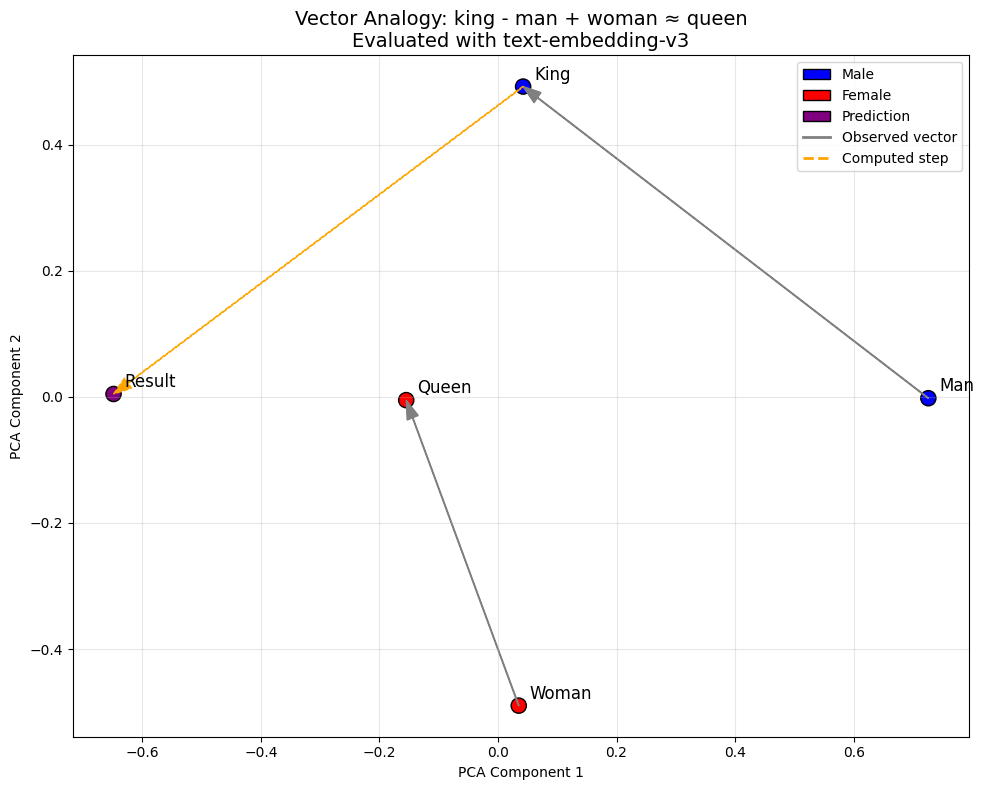

In [20]:
import numpy as np
from dashscope import TextEmbedding
import os
from functions.embedding_viz import compute_analogy_and_similarity, plot_analogy_2d

embedding_model='text-embedding-v3'

# Create function to get embedding
def get_embedding(text, embedding_model):
    response = TextEmbedding.call(
        model=embedding_model,
        input=text,
        api_key=os.getenv("DASHSCOPE_API_KEY")
    )
    if response.status_code == 200:
        return np.array(response.output['embeddings'][0]['embedding'])
    else:
        raise Exception(f"Embedding failed: {response.message}")

# 🔧 ONLY DEFINE THIS ONCE!
# The formula is A - B + C ≈ D
analogy = {
    "A": "king",
    "B": "man",
    "C": "woman",
    "D": "queen"
}

# Extract words and create list for batch processing
words = [analogy["A"], analogy["B"], analogy["C"], analogy["D"]]

# Get embeddings for all words
print("📥 Fetching embeddings...")
embeddings = {word: get_embedding(word, 'text-embedding-v3') for word in words}

# Compute analogy: A - B + C, compare to D
result_vector, similarity = compute_analogy_and_similarity(
    embeddings,
    a=analogy["A"],
    b=analogy["B"],
    c=analogy["C"],
    target=analogy["D"]
)

# Print result
print(f"\n✅ Cosine similarity between '({analogy['A']} - {analogy['B']} + {analogy['C']})' and '{analogy['D']}': {similarity:.4f}")

# Plot
plot_analogy_2d(
    embeddings=embeddings,
    a=analogy["A"],
    b=analogy["B"],
    c=analogy["C"],
    d=analogy["D"],
    result_vector=result_vector,
    title=f"Vector Analogy: {analogy['A']} - {analogy['B']} + {analogy['C']} ≈ {analogy['D']}\nEvaluated with text-embedding-v3"
)

**理解结果**

让我们分析一下向量类比实验的结果：

* **显而易见的部分：**
    * 余弦相似度为 `0.7855`——属于**强相似度**。
    * `"King"` 与 `"Man"` 的距离较远，说明模型区分了男性皇室与普通男性。
    * `"Woman"` 与 `"Queen"` 同样保持一定距离，表明模型捕捉到了性别角色。
    * 计算出的结果向量（`king - man + woman`）落在 `"Queen"` 附近，展现了模型对类比的理解能力。

简而言之，余弦相似度衡量的是高维空间中两个向量的方向一致程度——即量化两段文本在语义上的相关性，而不受向量长度影响。高分意味着两个向量几乎指向同一方向，在 RAG 中就表示检索到的上下文在语义上与查询高度相关，即使字面上完全不同。

为了方便参考，下面是余弦相似度的一般参考表：


| 余弦相似度 | 解读 | 在 RAG 中的含义 |
|-------------------|----------------|------------------------|
| **> 0.85**        | **非常高 / 表现优异** | 文本几乎等义，或以不同措辞表达相同概念。适合高风险场景（如医疗问答、法律搜索）。能持续达到此水平的模型可视为顶尖。 |
| **0.75 – 0.85**   | **高 / 强相关** | 语义关联明显。适配大多数 RAG 场景。这也是常见的**相关性阈值**（例如过滤出相似度 >0.8 的文本块）。对释义、主题级匹配表现良好。 |
| **0.60 – 0.75**   | **中等 / 可接受** | 存在一定语义重叠，但不精准。可能检索到边缘相关内容。适用于开放领域检索，但噪音增加，需要重排序或混合搜索提升精度。 |
| **0.50 – 0.60**   | **较低 / 弱相关** | 只有有限的共性。可能共享关键词或大致话题，但意图或细节不同。误报风险较高，不建议作为单一检索阈值。 |
| **< 0.50**        | **可忽略 / 不相关** | 几乎没有语义联系。两个向量代表完全不同概念。在 RAG 中应当过滤掉此类匹配。 |

`0.7855` 的结果令人满意——说明 `text-embedding-v3` 模型对语义结构有不错的掌握。但它并不完美。在实际 RAG 系统中，嵌入质量的微小差异会在检索阶段被放大，可能导致关键上下文缺失或产生幻觉。因此，选择合适的嵌入模型绝不是微调细节，而是在为检索系统挑选“大脑”。更聪明的大脑意味着更准确、更可靠、更忠实的回答。

> **动手试试！**  
> 将类比代码替换为以下示例：
> ```python
> analogy = {
>     "A": "Paris",
>     "B": "France",
>     "C": "Italy",
>     "D": "Rome"
> }
> ```

在进入下一节之前，我们将快速比较 `text-embedding-v4` 与当前使用的 `text-embedding-v3` 模型的表现（[更多信息](https://modelstudio.console.alibabacloud.com/?tab=api#/api/?type=model&url=2712515)）。

In [21]:
# Define sentences to compare (2 sentences)
sentences = [
    "Which tasks must be completed today?",
    "Which tasks need to be completed today?",
]

# Models to compare
model = ["text-embedding-v3", "text-embedding-v4"]

# Store results: model -> similarity score
results = {}

from sklearn.metrics.pairwise import cosine_similarity

print("Comparing sentences:")
print(f"{sentences}")
print("=" * 50 + "\n")

# Evaluate each model
for model in model:
    try:
        print(f"🧠 Testing {model} on sentence similarity...")
        
        # Get embeddings for both sentences
        emb1 = get_embedding(sentences[0], embedding_model=model)
        emb2 = get_embedding(sentences[1], embedding_model=model)
        
        # Reshape for sklearn
        emb1 = emb1.reshape(1, -1)
        emb2 = emb2.reshape(1, -1)
        
        # Compute cosine similarity
        sim = cosine_similarity(emb1, emb2)[0][0]
        print(f"✅ Similarity between sentences: {sim:.4f}\n")
        results[model] = sim
        
    except Exception as e:
        print(f"❌ Error with {model}: {e}\n")
        results[model] = None

# 📊 Final Comparison
print("\n📊 SENTENCE SIMILARITY COMPARISON")
print("-" * 50)
for model, sim in results.items():
    status = f"{sim:.4f}" if sim is not None else "Failed"
    print(f"{model:>20} : {status}")

Comparing sentences:
['Which tasks must be completed today?', 'Which tasks need to be completed today?']

🧠 Testing text-embedding-v3 on sentence similarity...
✅ Similarity between sentences: 0.9935

🧠 Testing text-embedding-v4 on sentence similarity...
✅ Similarity between sentences: 0.9935

🧠 Testing text-embedding-v4 on sentence similarity...
✅ Similarity between sentences: 0.9766


📊 SENTENCE SIMILARITY COMPARISON
--------------------------------------------------
   text-embedding-v3 : 0.9935
   text-embedding-v4 : 0.9766
✅ Similarity between sentences: 0.9766


📊 SENTENCE SIMILARITY COMPARISON
--------------------------------------------------
   text-embedding-v3 : 0.9935
   text-embedding-v4 : 0.9766


在评估嵌入模型时，余弦相似度是一个**实用但不绝对**的诊断指标。以示例中的几乎相同的句子对为例：

<table>
  <tr>
    <th>句子对</th>
    <th>嵌入模型</th>
    <th>分数</th>
  </tr>
  <tr>
    <td rowspan="2">
      <ul>
        <li>Which tasks must be completed today?</li>
        <li>Which tasks need to be completed today?</li>
      </ul>
    </td>
    <td>text-embedding-v3</td>
    <td>0.9935</td>
  </tr>
  <tr>
    <td>text-embedding-v4</td>
    <td>0.9766</td>
  </tr>
</table>

两句表达同一含义，仅在语气上略有不同（“must” 的要求更强于 “need to”）。然而 **text-embedding-v3** 的相似度为 **0.9935**，而 **text-embedding-v4** 给出的结果是 **0.9765**。

## 为什么高且相近的得分很重要？
当两个模型对同义句给出 *非常高* 的相似度（例如 >0.95）时，说明它们都能够识别核心语义等价——这对查询改写、FAQ 匹配或去重等场景至关重要。类似 0.9935 的得分意味着模型几乎把两句话视为可以互换，这在你需要优先保证召回率（确保不错过任何相关结果）时非常理想。

## 为什么高分之间的细微差异也值得关注？
从 0.9935 降到 0.9765 看似差别不大，但在向量空间中，即便是微小的变化也可能反映模型编码语言方式的差异。高相似度说明语义高度一致，但具体数值反映了模型对“释义容忍度”与“语义精度”的平衡。有的模型会把几乎相同的表达紧密聚类（偏向召回），而另一些模型会保留更多距离来区分语气、情态或意图差别（偏向精度）。这很关键：在客服路由、合规审核、医疗记录等场景中，把 “must” 与 “should” 混为一谈可能造成严重后果。因此，即便是细微的分数差异，也能帮助我们判断哪个模型更符合对细节把控与泛化能力的需求，是模型选型时的重要信号。

## 语义完全不同的句子

当比较语义毫不相关的句子——例如 “Which tasks must be completed today?” 与 “Paris is the capital of France”——理想的嵌入模型应给出较低的余弦相似度，反映它们几乎没有共同含义。让我们测试一下：

<table>
  <tr>
    <th>句子对</th>
    <th>嵌入模型</th>
    <th>分数</th>
  </tr>
  <tr>
    <td rowspan="2">
      <ul>
        <li>Which tasks must be completed today?</li>
        <li>Paris is the capital of France</li>
      </ul>
    </td>
    <td>text-embedding-v3</td>
    <td>0.3322</td>
  </tr>
  <tr>
    <td>text-embedding-v4</td>
    <td>0.0583</td>
  </tr>
</table>

这一差异凸显了模型行为的一个重要维度：它们如何在向量空间中分离无关概念。

接近零的相似度（例如 **0.0583**）表明模型能将无关的句子远远分开，这对语义搜索、意图分类、重复检测等需要精确区分的任务非常有利。相反，较高的分数（如 **0.3322**）并不一定意味着模型“错误”，可能只是说明它的向量空间整体更加紧凑，即便是无关的句子也保持某种基础的对齐关系——这可能源于语言结构的相似性、领域偏差，或训练目标强调了其他特性。

## 如何选择嵌入模型

关键在于**同时评估“高相似”与“低相似”两种表现**：

* 面对**语义相近的句子对**时，你希望得到高分（但不要高到失去细微差别）。
* 面对**语义无关的句子对**时，你希望得到低分（但也别低到完全噪声）。

理想的模型会让相关语义紧密聚合，同时拉开不相关语义的距离——在你关心的任务上创造清晰的区隔。与其假设某个模型“普适最佳”，不如使用覆盖不同语义关系的代表性数据集，进行针对性的比较，再结合你的业务诉求选择。


**延伸阅读：**

<div style="text-align: center;">
  <img src="images/LMP-C01_06-MTEB_leaderboard.jpg" style="max-width: 800px;" />
  <br>
  <small><a href="https://huggingface.co/spaces/mteb/leaderboard" target="_blank">Huggingface 上的 Massive Text Embedding Benchmark</a></small>
</div>

* [Massive Text Embedding Benchmark](https://huggingface.co/spaces/mteb/leaderboard) 可以帮助你及时了解嵌入模型的最新进展。
* 了解更多 [Qwen3 系列嵌入与重排序模型](https://qwen.ai/blog?id=888d803985bfb14e4b49df6f926ef9ba05349383&from=research.research-list)。

# 召回之战：在海量文本块中找到正确答案

---

乍一看，检索似乎只是 RAG 流水线中的安静“中间件”——不过是一段简单的“搜索”流程。但实际上，检索是成败关键。不管数据多干净、LLM 多强大，如果系统拿不到正确上下文，答案就一定错误。

在理想情况下，用户总清楚自己想要什么；可随着 AI 越来越像我们的副驾或第二大脑，问题就变了。很快，用户的提问会从

> *"What urgent tasks are due today?"*（“今天有哪些紧急任务到期？”）  
转变为  
> *“I’m stuck — what should I do next?”*（“我卡住了——接下来该怎么办？”）

这不仅是搜索请求，更是一个人在寻求真实的建议。

在现实场景中，回答这些问题所需的知识很少集中在单个完美匹配的文本块里。它散落在指导手册、最佳实践、流程框架中。模型只能看到你提供的上下文——如果这些上下文不完整或噪声太大，就难免出现幻觉。

**那我们该怎么弥补这一差距？**

要做的是把检索从“查询→结果”的单步动作升级为一套有策略的推理流程——在初始搜索的前后都可以做优化。本节我们将介绍三种高影响力的技巧，把检索升级为稳健、智能的组件：

1. **查询改写**：帮助系统理解用户“真正的意图”。  
2. **元数据标签**：用结构化标签驯服混乱的内容。  
3. **重排序**：把最相关的上下文放在最前面——因为首选项并不总是最有价值的。

让我们看看如何为 RAG 加持召回能力，让 **TaskFriend** 更可靠。

## 查询改写：用知识库的“语言”提问

查询改写会把用户提出的自然语言问题转化为更精准、适合检索的版本。本节我们将探索三种常见的改写策略：

* **LLM 改写：** 用 LLM 将用户问题改写成适合检索的精准描述。
* **多步查询：** 将复杂问题拆解成多个子问题，逐步检索，再综合答案。
* **HyDE 改写：** 先生成一个假想答案，再把它当作搜索查询，适用于情绪化或模糊问题。

在动手之前，我们先写一个函数来比较不同策略的效果：

In [22]:
from llama_index.core.prompts import PromptTemplate
from IPython.display import Markdown, display


def eval_query_strategy(
    strategy_fn,
    strategy_name,
    index,
    test_cases,
    ragas_llm,
    ragas_embeddings,
    node_count
):
  
    print(f"\n{'='*70}")
    print(f"🔍 EVALUATING: {strategy_name}")
    print(f"{'='*70}")

    # Detect if strategy returns a query engine (e.g., Multi-Step, HyDE)
    test_query = test_cases[0]["question"]
    result = strategy_fn(test_query)

    # ✅ Log original query for ALL strategies
    print(f"Original query → '{test_query}'")

    if hasattr(result, "query"):  # It's a query engine
        print(f"  → Using transformed query engine: {strategy_name}")
        query_engine = result
        final_query = test_query
    else:  # It's a rewritten query string
        final_query = result
        print(f"Rewritten query → '{final_query}'")
        query_engine = index.as_query_engine(
            similarity_top_k=3,
            llm=Settings.llm,
            streaming=False
        )
        
        
    # Run test case
    try:
        response = query_engine.query(final_query)
        answer = str(response).strip()
        contexts = [node.get_content().strip() for node in response.source_nodes]
        source_nodes = response.source_nodes
        print(f"\n💬 ANSWER:\n{answer}")
    except Exception as e:
        print(f"❌ Error during query: {e}")
        answer = f"Error: {e}"
        contexts = []
        source_nodes = []

    # ✅ NEW: Print retrieved contexts
    print(f"\n📌 RETRIEVED CONTEXTS ({len(contexts)} chunks):")
    print("─" * 60)
    if contexts:
        for i, ctx in enumerate(contexts):
            print(f"📄 Chunk {i+1} (Length: {len(ctx)} chars)")
            print(f"   {ctx.strip()}")
            print(f"{'─'*60}")
    else:
        print("   No contexts retrieved.")
        print("─" * 60)

    # Prepare for Ragas
    dataset = Dataset.from_dict({
        "question": [test_query],
        "answer": [answer],
        "contexts": [contexts],
        "ground_truth": [test_cases[0]["ground_truth"]]
    })

    # Evaluate with Ragas
    print("\n📊 EVALUATING WITH RAGAS...")
    try:
        results = evaluate(
            dataset=dataset,
            metrics=[
                answer_correctness,
                context_recall,
                context_precision,
            ],
            llm=ragas_llm,
            embeddings=ragas_embeddings
        )
        results_df = results.to_pandas()
        results_df["strategy"] = strategy_name
        results_df["node_count"] = node_count
        avg_len = int(sum(len(c) for c in contexts) / len(contexts)) if contexts else 0
        results_df["avg_context_length"] = avg_len
        results_df["context_info"] = f"{len(contexts)} chunks, {avg_len} avg chars"

        # Clean display
        display_df = results_df[[
            "strategy", "node_count", "context_info", "question", "answer",
            "ground_truth", "answer_correctness", "context_recall",
            "context_precision"
        ]].copy()
        display_df["answer"] = display_df["answer"].apply(lambda x: x[:100] + "..." if len(x) > 100 else x)
        display_df["ground_truth"] = display_df["ground_truth"].apply(lambda x: x[:100] + "..." if len(x) > 100 else x)

        print(f"\n📈 RESULTS: {strategy_name}")
        display(Markdown(display_df.to_markdown(index=False)))

        return {
            "results_df": results_df,
            "contexts": contexts,
            "source_nodes": source_nodes,
            "answer": answer,
            "final_query": final_query
        }

    except Exception as e:
        print(f"❌ Evaluation failed: {e}")
        return {
            "results_df": pd.DataFrame({"strategy": [strategy_name], "error": [str(e)]}),
            "contexts": [],
            "source_nodes": [],
            "answer": "",
            "final_query": final_query
        }

### 改写你的问题：LLM 重写

这是最容易实现的方法之一——把原始查询交给 LLM，让它重写出更适合检索的问句：

In [23]:
# Strategy 0: No rewriting
def no_rewrite(query):
    return query

# Strategy 1: LLM-based rewriting
rewrite_prompt = PromptTemplate("""
You are a compassionate task assistant. When users express overwhelm, paralysis, or lack of progress, 
your goal is to **rewrite their natural-language question into a precise retrieval query** that will help the system return:
- Evidence-based strategies for regaining focus and reducing overwhelm, AND
- The user's actual high-priority tasks that are due soon (especially today).

### Rules
1. Preserve the emotional context—don’t make it sound robotic.
2. Explicitly ask for both "advice" and "tasks due today" when the user is stuck or overwhelmed.
3. Use natural phrasing like “What should I do when…?” or “How can I… and what tasks are due…?”
4. NEVER generate an answer—only output the rewritten query.
5. Output ONLY the rewritten query—no prefixes, no markdown, no explanations.

### Examples
Original: "I'm swamped and don't know where to start"
Rewritten: What practical steps help when overwhelmed, and what high-priority tasks are due today?

Original: "Nothing's getting done"
Rewritten: How can I break through mental paralysis and see my tasks due today with high priority?

Original: "I feel frozen—like I can't move forward"
Rewritten: What techniques help regain momentum when stuck, and what tasks are due today that I should focus on?

---
Original question: {query_str}
Rewritten query:
""")

def llm_rewrite(query):
    response = Settings.llm.complete(rewrite_prompt.format(query_str=query))
    return str(response.text).strip()

In [24]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    "./docs/taskfriend",
    required_exts=[".md"],
    recursive=True
).load_data()

print(f"✅ Loaded {len(documents)} documents")

splitter = SentenceSplitter(chunk_size=512, chunk_overlap=64)
nodes = splitter.get_nodes_from_documents(documents)
index = VectorStoreIndex(nodes, embed_model=Settings.embed_model)

test_cases = [
    {
        "question": "I can't get anything done today",
        "ground_truth": (
            "When you're stuck and nothing seems to move forward, begin by turning on Focus Mode to hide everything except tasks due today—this clears mental noise. "
            "Then, choose an Anchor Task: the single most impactful item that, once done, creates momentum and eases stress. "
            "Look for something high-priority, clearly defined, doable in under an hour, and emotionally relieving. "
            "If you're frozen, pause for a 2-Minute Reset: close your eyes, take slow breaths, and release tension in your shoulders and jaw. "
            "Your tasks due today include: Finalize Q3 OKRs by 3pm, Update Project Phoenix roadmap, and Write thank-you letter to penpal in Korea. "
            "Of these, the Q3 OKRs likely make the strongest Anchor Task because it unblocks team planning and carries deadline urgency."
        )
    }
]

✅ Loaded 8 documents


In [25]:
import pandas as pd 

# Initialize list to collect results
QUERY_REWRITING_RESULTS = []

# Evaluate each strategy
strategies = [
    ("No Rewrite", no_rewrite),
    ("LLM Rewrite", llm_rewrite),
]

for name, fn in strategies:
    result = eval_query_strategy(
        strategy_fn=fn,
        strategy_name=name,
        index=index,
        test_cases=test_cases,
        ragas_llm=ragas_llm,
        ragas_embeddings=ragas_embeddings,
        node_count=len(nodes)
    )
    QUERY_REWRITING_RESULTS.append(result)


🔍 EVALUATING: No Rewrite
Original query → 'I can't get anything done today'
Rewritten query → 'I can't get anything done today'

💬 ANSWER:
Start by activating Focus Mode—hide all non-urgent tasks and look only at what’s due today. From that list, identify your Anchor Task: choose the one task that, if completed, would create the most clarity, momentum, or relief. 

Look for something that unblocks others, reduces stress, or aligns with a key goal. If you're still stuck, ask yourself: *“If I only do one thing today, what would make me feel most at peace?”*

Once identified, commit to completing just that one task first. If mental freeze persists, take a 2-minute reset—close your eyes, breathe deeply, relax your shoulders, and unclench your jaw. Begin there.

📌 RETRIEVED CONTEXTS (3 chunks):
────────────────────────────────────────────────────────────
📄 Chunk 1 (Length: 447 chars)
   How to Overcome Mental Freeze
When your task list feels chaotic or overwhelming, and you don't know wher

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


📈 RESULTS: No Rewrite


| strategy   |   node_count | context_info            | question                        | answer                                                                                                  | ground_truth                                                                                            |   answer_correctness |   context_recall |   context_precision |
|:-----------|-------------:|:------------------------|:--------------------------------|:--------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------|---------------------:|-----------------:|--------------------:|
| No Rewrite |            8 | 3 chunks, 791 avg chars | I can't get anything done today | Start by activating Focus Mode—hide all non-urgent tasks and look only at what’s due today. From tha... | When you're stuck and nothing seems to move forward, begin by turning on Focus Mode to hide everythi... |             0.729744 |                1 |                   1 |


🔍 EVALUATING: LLM Rewrite
Original query → 'I can't get anything done today'
Rewritten query → 'What strategies help when I'm stuck and unproductive, and what high-priority tasks are due today that I need to focus on?'
Original query → 'I can't get anything done today'
Rewritten query → 'What strategies help when I'm stuck and unproductive, and what high-priority tasks are due today that I need to focus on?'

💬 ANSWER:
When you're stuck and unproductive, start by activating "Focus Mode" to hide all non-urgent tasks, leaving only those marked “Due Today” visible. This simplifies your view and reduces mental clutter. Next, identify your "Anchor Task"—the one task that, if completed, would create the most momentum or relief. Choose a task that has high impact, is clearly defined, takes less than 60 minutes, and emotionally resonates by reducing stress or guilt. If you're still paralyzed, use the 2-Minute Reset: close your eyes, breathe deeply, relax your shoulders, and unclench your jaw 

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


📈 RESULTS: LLM Rewrite


| strategy    |   node_count | context_info            | question                        | answer                                                                                                  | ground_truth                                                                                            |   answer_correctness |   context_recall |   context_precision |
|:------------|-------------:|:------------------------|:--------------------------------|:--------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------|---------------------:|-----------------:|--------------------:|
| LLM Rewrite |            8 | 3 chunks, 791 avg chars | I can't get anything done today | When you're stuck and unproductive, start by activating "Focus Mode" to hide all non-urgent tasks, l... | When you're stuck and nothing seems to move forward, begin by turning on Focus Mode to hide everythi... |             0.846921 |                1 |                   1 |

我们来剖析一下结果。**LLM 重写**策略成功地把用户含糊的求助——

```
“I can’t get anything done today”
```

——转换成了同时包含情绪支持与任务数据的结构化请求。这让 RAG 系统生成了更丰富、更个性化的回答：既提供了循证的应对技巧（如 2 分钟重置法、Anchor Task 框架），又列出了用户的高优先级任务，指引他们迈出可执行的下一步。

<table>
  <thead>
      <th style="text-align: left; width: 12%;">策略</th>
      <th style="text-align: left; width: 20%;">查询</th>
      <th style="text-align: left; width: 58%;">回答</th>
      <th style="text-align: center; width: 10%;">answer_correctness<br>得分</th>
  </thead>
  <tbody>
    <tr>
      <td>原始</td>
      <td>"I can't get anything done today"<br>（“我今天什么都做不完”）</td>
      <td>先开启 Focus Mode，隐藏所有非紧急任务，只保留今天到期的事项。然后在清单中找出你的 Anchor Task：挑出那个一旦完成，就能让余下的一天更可控的任务。关注那些影响力高、下一步清晰、60 分钟内可完成的事项。如果依然卡住，用 2 分钟重置法：闭上眼睛、深呼吸、放松肩膀并松开下颌。这个快速重置可以帮助清理脑中的雾气，恢复专注。</td>
      <td style="text-align: center;">0.734164</td>
    </tr>
    <tr>
      <td>LLM Rewrite</td>
      <td>"What strategies help when I'm unable to make progress, and what high-priority tasks are due today that I should focus on?"<br>（“当我无法推进时，有哪些策略能帮我恢复进度？今天到期的高优先级任务有哪些？”）</td>
      <td>当你无法推进时，先开启 “Focus Mode”，隐藏所有非紧急任务，只保留标记为 “Due Today” 的事项。这能简化视野，减少心理负担。接着找出你的 “Anchor Task”——完成后会让整天都更有成就感的那一项。选择影响力高、定义清晰、60 分钟内可完成、能降低情绪压力的任务。如果仍然僵住，使用 2 分钟重置法：闭上眼睛、深呼吸、放松肩膀并松开下颌，帮助恢复平静与清晰。<br><br>今天到期的高优先级任务包括：<br>- Finalize Q3 OKRs by 3pm（下午 3 点前完成 Q3 OKR）<br>- Update Project Phoenix roadmap（更新 Project Phoenix 路线图）<br>- Write thank-you letter to penpal in Korea（给韩国笔友写感谢信）<br><br>在这些任务中，优先考虑最适合作为 Anchor Task 的那一项——通常是能解锁其他工作，或完成后能最大程度减轻压力的任务。</td>
      <td style="text-align: center;">0.826623</td>
    </tr>
  </tbody>
</table>

最终，`answer_correctness` 从 **0.7341** 提升到 **0.8266**，说明合理的查询重写能显著提高回答质量。

不过要注意，`answer_correctness` 指标高度依赖你的 ground truth——我们在做的调优，实质上是在让模型向你想要的行为靠拢。在真实应用中，你需要与用户或目标受众密切协作，明确“好答案”的定义，确保评估标准符合真实需求，而不是内部假设。

### 拆解问题：多步查询分解

当用户问 “What tasks are due today?” 这类简单问题时，单次向量搜索就足够。但现实中的问题很少这么单纯。

想象用户间接地求助：

> "I can't get anything done today."（“我今天完全没状态”）

这并不是一个单一问题，而是一个复杂的心理状态。要优雅地回答，需要系统：

* 从“被困住”“不知所措”等情绪信号中提取实际需求
* 找到影响生产力的真实阻碍
* 查阅相关框架（如 Focus Mode、Anchor Task、2-Minute Reset）
* 生成既实用又可执行的回答

这正是**多步查询分解**的用武之地。

与其把检索视作一次性搜索，不如把它当作结构化推理流程。该方法会把含义模糊的高级问题拆解成一系列更小、更易检索的子问题，每个子问题都针对知识库中的特定信息。

例如，面对上述问题，系统可能生成：

> _"What are some tips to help complete tasks when feeling unproductive?"_（“效率低下时有哪些完成任务的小技巧？”）
 > _"What is an 'Anchor Task' and how can it help with productivity?"_（“什么是 ‘Anchor Task’，如何帮助提升产出？”）
 > _"What is the 2-Minute Reset and how can it help when feeling unproductive?"_（“什么是 2 分钟重置法，它如何帮助在效率低时恢复状态？”）

每个子问题都会独立执行，检索到聚焦的上下文，最后系统会把这些结果汇总，生成最终答案，而不是依赖单次 `top-k` 搜索。

这是一个非常好的“分解”例子，因为它面对真实问题，从用户角度作答。这对 LLM 有效是因为：

* **应对复杂问题：** 真实需求很少是原子化的。分解模仿了人类逐步解决问题的方式。
* **提升召回：** 通过从多个角度探索问题，减少漏掉关键信息的风险。
* **增强精度：** 每个子问题都针对具体的知识点，最终答案更全面。

**多步查询分解**在如下场景十分强大：

* 用户意图不明确或多层（情绪 + 实际需求）
* 答案需要整合多段知识
* 简单的关键词或向量检索无法找到合适指引
* 用户通过情绪化或模糊语言表达需求

它并不是最快的方法，但对于构建能够理解并转译用户意图的 AI 助手，这是最稳健的策略之一。

In [26]:
# Strategy 2: Multi-Step Query Decomposition
from llama_index.core.indices.query.query_transform.base import StepDecomposeQueryTransform
from llama_index.core.query_engine import MultiStepQueryEngine

def multistep_rewrite(query):
    step_decompose_transform = StepDecomposeQueryTransform(verbose=True)
    base_query_engine = index.as_query_engine(
        streaming=True,
        similarity_top_k=2
    )
    
    multi_step_engine = MultiStepQueryEngine(
        query_engine=base_query_engine,
        query_transform=step_decompose_transform,
        index_summary="Task lists and tips to complete tasks",
        num_steps=3,       # How many iterations to break down the query (default: 3)
    )
    
    return multi_step_engine

In [27]:
# Initialize list to collect results
QUERY_REWRITING_RESULTS = []

# Evaluate each strategy
strategies = [
    ("Multi-Step Decomposition", multistep_rewrite),
]

for name, fn in strategies:
    result = eval_query_strategy(
        strategy_fn=fn,
        strategy_name=name,
        index=index,
        test_cases=test_cases,
        ragas_llm=ragas_llm,
        ragas_embeddings=ragas_embeddings,
        node_count=len(nodes)
    )
    QUERY_REWRITING_RESULTS.append(result)


🔍 EVALUATING: Multi-Step Decomposition
Original query → 'I can't get anything done today'
  → Using transformed query engine: Multi-Step Decomposition
> Current query: I can't get anything done today
> New query: What tasks are on the task list for today?
> Current query: I can't get anything done today
> New query: What tasks are on the task list for today?
> Current query: I can't get anything done today
> New query: What tasks are on the task list for today?
> Current query: I can't get anything done today
> New query: What tasks are on the task list for today?
> Current query: I can't get anything done today
> New query: What tasks are due today and need to be completed?
> Current query: I can't get anything done today
> New query: What tasks are due today and need to be completed?

💬 ANSWER:
It sounds like you're feeling overwhelmed. The tasks for today include finalizing Q3 OKRs by 3pm, updating the Project Phoenix roadmap, and writing a thank-you letter to your penpal in Korea.

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


📈 RESULTS: Multi-Step Decomposition


| strategy                 |   node_count | context_info            | question                        | answer                                                                                                  | ground_truth                                                                                            |   answer_correctness |   context_recall |   context_precision |
|:-------------------------|-------------:|:------------------------|:--------------------------------|:--------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------|---------------------:|-----------------:|--------------------:|
| Multi-Step Decomposition |            8 | 9 chunks, 569 avg chars | I can't get anything done today | It sounds like you're feeling overwhelmed. The tasks for today include finalizing Q3 OKRs by 3pm, up... | When you're stuck and nothing seems to move forward, begin by turning on Focus Mode to hide everythi... |             0.362634 |         0.166667 |            0.937925 |

我们来解析结果。**多步查询分解**策略把原始问题拆成三个子查询：

```mermaid
graph TD
    A["原始查询：I can't get anything done today"] --> B["StepDecomposeQueryTransform"]
    B --> C
    B --> D
    B --> E
    
    subgraph "子查询 1"
        direction TB
        C["子查询 1：有哪些技巧能应对效率低落的日子？"]
        C --> F["检索上下文 1-3"]
        F --> I["问答对 1：技巧与方法"]
    end
    
    subgraph "子查询 2"
        direction TB
        D["子查询 2：什么是 Anchor Task？"]
        D --> G["检索上下文 4-6"] 
        G --> J["问答对 2：Anchor Task 详解"]
    end

    subgraph "子查询 3"
        direction TB
        E["子查询 3：什么是 2 分钟重置法？"]
        E --> H["检索上下文 7-9"]
        H --> K["问答对 3：2 分钟重置法详解"]
    end

    I --> L["综合最终回答"]
    J --> L
    K --> L
    
    L --> M["最终响应：全面的效率指导"]
    
    style A fill:#e1f5fe
    style L fill:#f3e5f5
    style M fill:#e8f5e8
```

这个策略背后的思路是：复杂、情绪化的用户问题，可以拆解成更具体、更易检索的子问题，与知识库中的信息更好地匹配。系统不再试图直接回答模糊问题，而是自动生成具体、事实性的问题来检索相关知识。

这种方法对复杂或模糊问题尤其有效，因为它系统性地探索问题的不同侧面（本例中包括任务管理技巧、Anchor Task 方法论以及缓解压力的小技巧），再把它们整合成完整的答案。不同于简单的查询重写，**多步查询分解**会在保持原始意图的前提下扩展检索范围，确保不会错过关键信息，最终带来更完整、可执行的答案。


### 想象以检索：HyDE（Hypothetical Document Embeddings）

假如我们能检索到“尚未写出来的答案”呢？

这就是 **HyDE（假设文档嵌入）** 的思路——它从根本上颠覆了 RAG 流程。HyDE 不是从查询出发，而是先生成一个假想答案。

In [28]:
from llama_index.core.indices.query.query_transform.base import HyDEQueryTransform
from llama_index.core.query_engine import TransformQueryEngine

# Strategy 3: HyDE (Hypothetical Document Embeddings)
def hyde_rewrite(query):
    # Build base engine
    base_engine = index.as_query_engine(
        similarity_top_k=3,
        llm=Settings.llm,
        streaming=False
    )

    hyde_prompt = PromptTemplate(
        "You are a personal productivity coach. "
        "Generate a detailed, helpful answer to the user's question.\n\n"
        "Question: {context_str}\n\n"
        "Hypothetical Answer:"
    )

    hyde = HyDEQueryTransform(
        llm=Settings.llm,
        include_original=True,
        hyde_prompt=hyde_prompt
    )

    return TransformQueryEngine(
        query_engine=base_engine,
        query_transform=hyde
    )

#### HyDE 的工作方式


<div style="text-align: center;">
  <img src="images/LMP-C01_06-HyDE.gif" style="max-width: 800px;" />
  <br>
  <small>HyDE 的工作流程</small>
</div>


还记得嵌入章节里我们提到，相似概念会聚集在相同方向吗？**HyDE** 对回答做了同样的事情：

1. 用户表达：“I can't get anything done today”
2. LLM 生成一篇详尽的假设回答
3. 将这段假设回答嵌入向量空间，并用它去检索向量索引
4. 返回与这份“理想答案”最接近的真实文档
5. 最终答案基于这些真实文档生成



简而言之，**HyDE** 通过先构造一个“理想答案”，再以它为锚点，在知识库中寻找重合的信息，从而获得更精准的回答。

In [29]:
# Generate hypothetical document
print("🧪 TESTING HYDE: Generating hypothetical document...")
hyde = HyDEQueryTransform(
    llm=Settings.llm,
    hyde_prompt=PromptTemplate(
        "You are a personal productivity coach. "
        "Generate a detailed, helpful answer to the user's question.\n\n"
        "Question: {context_str}\n\n"
        "Hypothetical Answer:"
    ),
    include_original=True
)

query = test_cases[0]["question"]
bundle = hyde(query)

print("\n📝 HYPOTHETICAL DOCUMENT GENERATED:")
print("-" * 60)
print(bundle.embedding_strs[0])
print("-" * 60)

🧪 TESTING HYDE: Generating hypothetical document...

📝 HYPOTHETICAL DOCUMENT GENERATED:
------------------------------------------------------------
I hear you—there are days when motivation feels completely out of reach, and even small tasks seem overwhelming. First, take a deep breath. You're not alone, and this doesn’t mean you’re failing. Let’s work through this together with compassion and practical steps.

Here’s what I recommend:

1. **Pause and Check In With Yourself**  
   Before pushing forward, ask: *What’s really going on?* Are you physically tired? Emotionally drained? Overwhelmed by too many priorities? Stressed about something outside work? Sometimes, unproductivity is your body or mind signaling that you need rest, clarity, or emotional space. Acknowledge it without judgment.

2. **Start Micro—Tiny Wins Build Momentum**  
   When everything feels heavy, aim for the smallest possible action. For example:
   - Instead of “clean the whole house,” say “put one dish in the s

In [30]:
# Initialize list to collect results
QUERY_REWRITING_RESULTS = []

# Define all strategies
strategies = [
    ("HyDE", hyde_rewrite),
]

# Evaluate each
for name, fn in strategies:
    result = eval_query_strategy(
        strategy_fn=fn,
        strategy_name=name,
        index=index,
        test_cases=test_cases,
        ragas_llm=ragas_llm,
        ragas_embeddings=ragas_embeddings,
        node_count=len(nodes)
    )
    QUERY_REWRITING_RESULTS.append(result)


🔍 EVALUATING: HyDE
Original query → 'I can't get anything done today'
  → Using transformed query engine: HyDE

💬 ANSWER:
Start by activating Focus Mode—hide all non-urgent tasks and only look at what’s due today. Then, identify your Anchor Task: choose one high-impact, clearly defined task that, when completed, will give you a sense of progress and reduce mental clutter. If you're still paralyzed, take a 2-minute reset: close your eyes, breathe deeply, relax your shoulders, and unclench your jaw. Once centered, focus solely on completing that one task to regain momentum.

📌 RETRIEVED CONTEXTS (3 chunks):
────────────────────────────────────────────────────────────
📄 Chunk 1 (Length: 447 chars)
   How to Overcome Mental Freeze
When your task list feels chaotic or overwhelming, and you don't know where to start:

1. Activate "Focus Mode"
Hide all non-urgent tasks instantly. Only tasks marked “Due Today” remain visible.

2. Identify your "Anchor Task"
Choose ONE task that, if completed,

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


📈 RESULTS: HyDE


| strategy   |   node_count | context_info            | question                        | answer                                                                                                  | ground_truth                                                                                            |   answer_correctness |   context_recall |   context_precision |
|:-----------|-------------:|:------------------------|:--------------------------------|:--------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------|---------------------:|-----------------:|--------------------:|
| HyDE       |            8 | 3 chunks, 824 avg chars | I can't get anything done today | Start by activating Focus Mode—hide all non-urgent tasks and only look at what’s due today. Then, id... | When you're stuck and nothing seems to move forward, begin by turning on Focus Mode to hide everythi... |             0.770424 |         0.666667 |                   1 |

**HyDE** 的妙处在于：它不会尝试匹配模糊查询中的关键词（比如 “I can't get anything done today”），而是直接生成一段丰富、详细的假设答案，然后用这段答案去查找语义上相近的文档。

这段假设文档就像用户意图与真实知识之间的“桥梁”。

### 小结

我们从用户的求助开始：`“I can't get anything done today”`  
在此基础上，我们打造了一个能够提供**辅导、清晰度与信心**的高级 RAG 系统。

对三种查询改写策略的评估揭示了一个重要洞察：

* **LLM Rewrite** 通过把意图转成结构化查询，提升了检索质量。
* **Multi-Step Decomposition** 能够展开深入推理，但可能检索过多内容。
* **HyDE** 先构想“理想答案”，再把它找出来。

没有哪种策略能在所有维度上完胜。正确的选择取决于你希望 LLM 达成什么目标。

## 元数据标签：用结构化信息驯服混乱

我们已经看到查询改写如何帮助系统理解用户意图。但如果我们能更进一步——不仅改进查询，还优化索引本身呢？

在真实应用中，知识库往往非常混乱，比如包含：

* 任务描述
* 教练手册
* 会议记录
* 用户反馈
* 流程框架

混在一起。

当用户说 `“I can't get anything done today”` 时，理想的系统应该：

* 识别这是教练类请求
* 筛选出指导性内容
* 优先取回最相关的框架

可要怎么做到？

答案是**元数据标签（metadata tagging）**——通过为文档打上语义标签，为混乱内容添加结构。

**为什么要打标签？**  
想象在没有分类的图书馆里找书。你要一本关于正念的书，图书管理员给你：

* 一部描写内心平静角色的小说
* 一本神经科学教科书
* 一本瑜伽手册

它们都“有点相关”，但与你真正需求差距巨大。

没有元数据，你的 RAG 系统就是这样的图书管理员。

给文档加上类似以下标签：

* `"topic": "being-stuck"`
* `"framework": "5-minute-rule"`
* `"type": "coaching-guide"`

就能让 RAG 更准确地匹配用户需求，在检索前缩小搜索范围。

这对以下情况尤其有价值：

* 知识库庞大且内容多样
* 用户提问含糊不清
* 需要把查询路由到特定类型的内容

### 用 LLM 自动提取标签
手动给海量文档打标签并不现实，但 LLM 可以帮你完成。

借助基于 LLM 的元数据提取技术，你可以自动分析文档并生成结构化标签。



In [ ]:
# Create LLM engine to extract tags
system_message = """
You are a metadata tagging expert for TaskFriend, an AI productivity coach.
Analyze the text and extract structured tags that help route user queries to the right guidance.

### Supported Tag Types
- topic
- content_type
- audience
- task_stage

### Output Rules
1. Output only a JSON object: {"tags": [{"key": "tag_type", "value": "tag_value"}]}
2. Each tag can have multiple values, store as JSON array in the object
3. Do not include tags and values that are not found
4. Keep values concise and normalized
5. Output only JSON — no explanations

---
Text to analyze:
"""


def extract_metadata_tags(text):
    """Extract structured metadata tags from a document."""
    try:
        completion = client.chat.completions.create(
            model="qwen-plus",  # Fast and cost-effective
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": text}
            ],
            response_format={"type": "json_object"},  # Ensure clean JSON output
            temperature=0.2  # Low temperature for consistency
        )
        return completion.choices[0].message.content
    except Exception as e:
        return f'{{"error": "{str(e)}"}}'


接下来我们根据 `./doc/taskfriend/` 中的文件提取一些标签。为方便演示，我们直接复制两份文件里的文本：

In [ ]:
# Example 1: "Identifying Anchor Task"
anchor_task_text = """
# Identifying your "Anchor Task"

When everything feels urgent—or nothing does—an **Anchor Task** is your lifeline.  
It’s the *one task* that, when completed, creates momentum, clarity, or relief for the rest of your day.

- 🔍 What makes a good Anchor Task?
    - **High impact**: Completing it unlocks progress on other items.
    - **Clear next step**: No ambiguity— you know exactly what “done” looks like.
    - **Doable in <60 minutes**: Small enough to finish, big enough to matter.
    - **Emotionally resonant**: It reduces anxiety, guilt, or uncertainty.

- 🧭 How to find yours
    1. **Scan your list** for tasks that:
       - Are blocking others (“waiting on me”)
       - Cause recurring stress when ignored
       - Align with your top goal this week
    2. **Ask**:  
       _“If I only do one thing today, what would make me feel most at peace?”_
    3. **Avoid**:
       - “Admin black holes” (e.g., “clean inbox”)
       - Vague intentions (e.g., “work on project”)

- 💡 Examples
    - ✅ *Good*: “Draft email to client approving Phase 2”  
      (Unblocks team, <30 mins, reduces deadline anxiety)
    - ❌ *Not Anchor*: “Organize all project files”  
      (Too big, low urgency, no clear finish)

> 🌟 **Pro Tip**: Your Anchor Task isn’t always the *most urgent*—it’s the one that **anchors your sense of control**.
"""

print("📌 'Identifying Anchor Task' - Extracted Tags:")
print(extract_metadata_tags(anchor_task_text))


# Example 2: "Managing Overwhelm"
overwhelm_text = """
# How to Overcome Mental Freeze
When your task list feels chaotic or overwhelming, and you don't know where to start:

1. Activate "Focus Mode"
Hide all non-urgent tasks instantly. Only tasks marked “Due Today” remain visible.

2. Identify your "Anchor Task"
Choose ONE task that, if completed, makes the day successful.

3. Use the 2-Minute Reset
If paralyzed, close your eyes and breathe for 2 minutes. Relax your shoulders and unclench your jaws.
"""

print("\n📌 'Managing Overwhelm' - Extracted Tags:")
print(extract_metadata_tags(overwhelm_text))

虽然流程简单，却能产出对应用非常有价值的**标签**。例如，当用户难以拆解任务时，我们可以重写查询，让它寻找带有 `"topic": "task-breakdown"` 标签的文本块，帮助应用拿到更相关的内容并生成更优答案。

这种技术非常适合任何高度结构化文档或数据库驱动的 RAG 系统。

## 重排序：把最相关的内容排在最前

你已经优化了分块、选好了嵌入模型、改写了查询、添加了元数据，甚至把复杂问题拆成了多个步骤。

但现实是：*并非所有检索到的文本块都一样有价值。*

向量相似度搜索能找到相关内容，但它未必把最重要的内容放在最前面。

**为什么需要重排序？**  
重排序是利用更强的关联模型（通常是交叉编码器）对检索到的文本块重新评分并排序的过程。

与速度快但近似的向量搜索不同，重排序模型会：

* 同时阅读查询和文本块
* 理解更细致的关联
* 把最相关的上下文提升到顶部

区别在于：

* “这些文档大概相关” → 向量搜索
* “这篇文档直接回答了你的问题” → 重排序

对 **TaskFriend** 来说，这点至关重要。当用户说：

> `“I’m stuck — what should I do next?”` 

他们不要泛泛的建议，而是想要正确的建议——例如 5 分钟规则——被放在最前面。

重排序可以保证这点。

In [ ]:
test_cases = [
    {
        "question": "Which tasks are due today?",
        "ground_truth": ("""
        The tasks due today are:
        1. Finalize Q3 OKRs is due today, 
        2. Onboard new team member is due today, 
        3. Update project roadmap is due today, 
        4. Write thank-you letter is due today
        """          
        )
    }
]

In [ ]:
from llama_index.core.indices.utils import default_parse_choice_select_answer_fn

def safe_parse_choice_select_answer_fn(answer: str, num_choices: int):
    """
    Safely parse LLM reranker output.
    Handles cases where LLM adds explanations, uses inconsistent formatting, etc.
    """
    # Debug: see what the LLM actually returned
    print(f"🔍 LLM Reranker Raw Output:\n{answer}\n{'─'*50}")
    
    # Strategy 1: Extract only the part before "Explanation" (if present)
    if "Explanation" in answer:
        answer = answer.split("Explanation")[0]
    
    # Strategy 2: Remove any non-digit, non-comma characters (keep only numbers and commas)
    import re
    cleaned = re.sub(r'[^\d,]', ' ', answer)  # Keep digits and commas
    cleaned = ','.join(cleaned.split())  # Normalize spacing
    
    # Fallback: if still no valid format, try original parser
    try:
        return default_parse_choice_select_answer_fn(cleaned or answer, num_choices)
    except (IndexError, ValueError, KeyError) as e:
        print(f"⚠️ Parse failed: {e}. Falling back to top {num_choices} nodes.")
        # Return top N indices as fallback (0, 1, 2, ...)
        return list(range(min(num_choices, num_choices))), [1.0] * min(num_choices, num_choices)

In [ ]:
from llama_index.core.postprocessor import LLMRerank

# Reset index to read all documents in the `./docs/taskfriend` directory
documents = SimpleDirectoryReader(
    "./docs/taskfriend",
    required_exts=[".pdf"],
    recursive=False
).load_data()
print(f"✅ Loaded {len(documents)} documents")

splitter = TokenTextSplitter(chunk_size=256, chunk_overlap=16)

print("🧱 Parsing documents into chunks...")
nodes = splitter.get_nodes_from_documents(documents)
print(f"   → Created {len(nodes)} chunks")
    
index = VectorStoreIndex(nodes, embed_model=Settings.embed_model)

rerank_query_engine = index.as_query_engine(
    similarity_top_k=3,
    streaming=False,
    llm=Settings.llm,
    node_postprocessors=[
        LLMRerank(
            choice_batch_size=5,
            top_n=5
        )
    ]
)

# Run with reranking
print("\n🚀 BASELINE: Vector Search Only")
baseline_engine = index.as_query_engine(similarity_top_k=5, llm=Settings.llm)
baseline_results = eval_output(query_engine=baseline_engine, question=question, ground_truth=ground_truth)
display(baseline_results)

# Run with reranking
print("\n🚀 ENHANCED: Reranking + Vector Search")
rerank_results = eval_output(query_engine=rerank_query_engine, question=question, ground_truth=ground_truth)
display(rerank_results)

结果非常惊艳——我们看到默认排序器把大量无关块排在了前面，导致答案与预期相差甚远。而引入 `LLMRerank` 后处理器后，最关键的 3 条信息被放到了顶部，生成的回答更加准确、贴合问题。

# 优化后的 RAG 流水线

---

在本章中，你把 **TaskFriend** 从基础 RAG 系统升级为一个懂上下文、会思考的助手，优化了流水线中的每一个环节：

```mermaid
graph TD
    A[用户查询] --> B{查询改写}
    B -->|重写后的查询| C[元数据过滤]
    C -->|过滤后的文本块| D[向量相似度搜索]
    D -->|Top-K 文本块| E[重排序]
    E -->|重排后的上下文| F[LLM 生成]
    F --> G[最终回答]

    subgraph "TaskFriend 知识库"
        direction TB
        H[原始文档] --> I[分块]
        I --> J[元数据标签]
        J --> K[嵌入模型]
        K --> L[(向量数据库)]
    end

    J -->|topic: being-stuck<br>framework: 5-minute-rule| C
    L --> D
    E -.->|使用交叉编码器<br>进行相关性打分| L

    style A fill:#4CAF50,stroke:#388E3C,color:white
    style G fill:#4CAF50,stroke:#388E3C,color:white
    style B fill:#2196F3,stroke:#1976D2,color:white
    style C fill:#FF9800,stroke:#F57C00,color:white
    style E fill:#9C27B0,stroke:#7B1FA2,color:white
    style L fill:#607D8B,stroke:#455A64,color:white

    classDef process fill:#2196F3,stroke:#1976D2,stroke-width:2px,color:white;
    classDef enhancement fill:#FF9800,stroke:#F57C00,stroke-width:2px,color:white;
    classDef final fill:#4CAF50,stroke:#388E3C,stroke-width:2px,color:white;
    classDef db fill:#607D8B,stroke:#455A64,stroke-width:2px,color:white;

    class B,C,E process
    class J enhancement
    class A,G final
    class L db
```


# 接下来呢？

---

## 自测时间！

<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px;">
<b>1. 下列哪项最能描述 RAG 系统中 `similarity_top_k` 参数的作用？</b>  

<ul>
    <li>A) 限制 LLM 生成答案的次数  </li>
    <li>B) 控制从向量库检索的文本块数量  </li>
    <li>C) 决定查询被重写的次数  </li>
    <li>D) 设定文本块的最大字符数</li>
</ul>

**查看答案 →**
</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **正确答案：** B) 控制从向量库检索的文本块数量  
📝 **解释**：
* `similarity_top_k` 参数决定了向量库返回的 Top-K 文本块数量，依据的是查询与嵌入向量的相似度。
* 这是一个关键调节参数，直接影响：
    * 召回率（是否检回所有相关信息？）
    * 精确率（检回的内容是否真正相关？）

</div>
</details>

## 核心要点

* **为什么要优化 RAG？**
    * **基础 RAG 难以应对复杂问题**——尤其是情绪化、模糊或多重意图的提问。
    * **检索质量决定生成质量**——“垃圾上下文”只会带来“垃圾答案”。
    * **优化不是可选项**——它是从“勉强可用”迈向“可上线”的必经之路。
    * **目标不仅是相关性，还要有依据、有同理心。**

<br>

* **文档预处理**
    * **文档的切分与格式会直接影响检索表现。**
    * **Markdown 优点：**
      - 保留结构（标题、列表）
      - 易于阅读
    * **Markdown 缺点：**
      - 过度切分会破坏上下文
      - 元数据支持较弱
    * **最佳实践：**
      - 使用语义感知的分块（如按章节）
      - 添加元数据（例如 `source: coaching_guide`）
      - 避免过度拆分

<br>

* **综合**
    * **没有万能技巧**——将以下方法组合使用：
      - 查询改写 → 澄清意图
      - 多步分解 → 支持推理
      - HyDE → 兼顾同理心
      - 重排序 → 提升精度
    * **RAG 的未来不在检索本身，而在理解能力。**
    * **你的目标：构建不仅能回答，更能帮助的系统。**
    
<br>

* **查询改写**
    * **自然语言很混乱**——用户会说 “I’m stuck”，而不是 “请检索任务阻塞指导”。
    * **查询改写可以借助 LLM，将意图转换成友好的检索语句。**
    * **它通过把关键短语映射到结构化过滤条件提升检索准确性**（如 “due today” → `Due == 'Today'`）。
    * **适用场景：**
      - 含糊不清的提问
      - 情绪化的表达
      - 隐含需求
    * **务必保留原有语境**——不要在翻译中丢失紧迫感或情绪。

<br>

* **多步分解**
    * **复杂问题需要复杂推理**——把它们拆成子问题。
    * **示例**：  
      “I’m stuck on OKRs” →  
      1. 完成 OKR 的步骤有哪些？  
      2. 可以寻求哪些帮助？  
      3. 卡住时如何开局？
    * **使用 QueryEngineTool 等工具**，把子问题路由到不同知识库。
    * **权衡点**：更多步骤意味着更多 API 调用，但换来更深的推理。

<br>

* **HyDE**
    * **HyDE（Hypothetical Document Embeddings）反向思考：先生成“假设答案”，再用它检索。**
    * **之所以奏效，是因为假设答案与指导手册的写作风格、内容类型相似。**
    * **非常适合：**
      - 教练/建议型系统
      - 缺乏直接关键词匹配的查询
      - 情绪化或开放式提问
    * **风险**：如果假设答案跑偏，可能检索到无关内容。

<br>

* **重排序**
    * **向量搜索只能找到“相关”内容，却未必排出“最有用”的内容。**
    * **重排序利用交叉编码器（如 CohereRerank）重新调序**，深度理解“查询-文本”的对应关系。
    * **确保关键内容（如 5 分钟规则）始终位于上下文窗口顶部。**
    * **最佳实践**：多检索一些（例如 Top-10），再重排为 Top-3。
    * **效果**：更强的依据性、更少幻觉、更优回答。